<center>

# Определение стоимости автомобилей

</center>

## Описание проекта.
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. <br><br>


- **Заказчик:**
Сервис по продаже автомобилей с пробегом «Не бит, не крашен».<br>

- **Целевые метрики заказчика:**
  - качество предсказания;
  - скорость предсказания;
  - время обучения.<br><br>

- **Целевая метрика ML:**
  - Минимизация `RMSE`.

### Цели работы:
- Построение модели ML, определяющей цены на подержанные автомобили клиентов.

### Описание данных.

- **Источник данных:** https://code.s3.yandex.net/datasets/autos.csv <br>

<center>

#### Описание признаков:

| Признак | Тип признака | Описание признака |
| :- | :- | :- |
Признаки:
DateCrawled | дата/время | дата скачивания анкеты из базы
VehicleType | категориальный | тип автомобильного кузова
RegistrationYear | категориальный | год регистрации автомобиля
Gearbox | категориальный | тип коробки передач
Power | количественный | мощность (л. с.)
Model | категориальный | модель автомобиля
Kilometer | количественный | пробег (км)
RegistrationMonth | категориальный | месяц регистрации автомобиля
FuelType | категориальный | тип топлива
Brand | категориальный | марка автомобиля
Repaired | категориальный | была машина в ремонте или нет
DateCreated | дата/время | дата создания анкеты
NumberOfPictures | количественный | количество фотографий автомобиля
PostalCode | категориальный | почтовый индекс владельца анкеты (пользователя)
LastSeen | дата/время | дата последней активности пользователя
Целевой признак:
Price | количественный | цена (евро)

</center><br>

## Загрузка используемых библиотек.

In [27]:
### os для обращения к среде разработки и requests для интернет запросов.
import os
import requests


### Работа с датафреймами.
# pandas для работы с датафреймами.
# !pip install --upgrade pandas --user -q
import pandas as pd
# функции проверки типа столбцов.
from pandas.api.types import is_numeric_dtype, is_object_dtype

### numpy для вычислений.
import numpy as np

### Phi_K для вычисления корреляции признаков.
!pip install phik -q
import phik
from phik.report import plot_correlation_matrix

### Визуализация.
# matplotlib для визуализации.
!pip install matplotlib --upgrade --user -q
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
# seaborn для визуализации.
!pip install seaborn --upgrade -q
import seaborn as sns
# probplot для построения вероятностных графиков.
from scipy.stats import probplot
# missingno для построения графика пропусков.
!pip install missingno -q
import missingno as msno

### Методы и классы для работы с моделями.
# Разделение выборок.
!pip install scikit-learn --upgrade -q
from sklearn.model_selection import train_test_split
# Классы для кодирования и трансформации признаков.
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder,
                                   StandardScaler, FunctionTransformer,
                                   QuantileTransformer)
## Методы и классы для работы с пайплайнами.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
## Модели.
# Константная модель.
from sklearn.dummy import DummyRegressor
# Линейная регрессия.
from sklearn.linear_model import LinearRegression
# Дерево решений.
from sklearn.tree import DecisionTreeRegressor
# Алгоритмы градиентного бустинга.
from sklearn.ensemble import HistGradientBoostingRegressor
!pip install catboost -q
from catboost import CatBoostRegressor
!pip install lightgbm -q
from lightgbm import LGBMRegressor
## Функции подбора гиперпараметров.
!pip install optuna -q
import optuna
## Метрики.
from sklearn.metrics import mean_squared_error, r2_score

### Модули для контроля времени и хода исполнения ячеек.
## tqdm для контроля выполнения ячеек;
from tqdm.notebook import tqdm
# time для замеров длительности обучения моделей.
from time import time
from time import perf_counter

### Дополнительные модули.
# Перевод регистра.
!pip install inflection -q
from inflection import underscore
# Контроль вывода предупреждений.
import warnings
### HTML для настройки отображения эл-тов.
from IPython.core.display import HTML

## Установка глобальных параметров проекта.

In [2]:
# Установим стиль отображения заголовков таблиц.
styles = [
    dict(selector='caption',
         props=[('text-align', 'center'),
                ('font-size', '130%'),
                ('font-weight', 'bold'),
                ('white-space', 'pre-wrap')]),
    dict(selector="th",
         props=[('max-width', '250px')])
    ]

# Установим отображение всех столбцов при выводе датафрейма.
pd.set_option('display.max_columns', 200)

# Также, игнорируем FutureWarning от Pandas, относящиеся к библиотеке Seaborn.
warnings.filterwarnings("ignore")

# Установим начальное значение генератора псевдослучайных чисел.
SEED = 42
np.random.seed(SEED)

# Установим отображение графиков по центру ячейки
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
</style>
""")

# Определение места хранения файлов отдельно для Google Colab.
if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import drive
    drive.mount('/content/drive/')

## Загрузка данных.
- Функция загрузки и записи в переменные любого количества датасетов в формате `.csv` с проверкой адреса/пути.

In [3]:
# Функция загрузки и записи в переменные любого количества датасетов в формате
# .csv по ссылкам или пути с проверкой адреса/пути.
def fetch_datasets(pths, separator=','):
    '''Arguments:
    - pths: str, list. Full string path in quotes or list of links or
    list of file paths as list of strings.
    - separator: str, default=','. Separator as a string.
    - Example: ('/datasets/file.csv' or ['https://datasets/file.csv'], 't').
    '''

    # Переведём путь в список при необходимости.
    pths = [pths] if isinstance(pths, str) else pths

    print("\n\033[1m",
          'Начало загрузки и записи датасетов в переменные:',
          "\033[0m")

    for pth in tqdm(pths):
        # Запишем название и расширение файла.
        full_name = os.path.basename(pth)
        name, extension = os.path.splitext(full_name)

        # Проверим ссылку и запишем датасет в переменную.
        if 'http' in pth:
            # Воспользуемся try/except для непредвиденных ошибок.
            try:
                # Проверим корректность ссылки.
                if requests.get(pth).status_code == 200:
                    # Создадим переменную и запишем в неё датафрейм.
                    globals()[name.lower()] = pd.read_csv(pth, sep=separator)
                    print(f'Файл {full_name} прочитан и записан в переменную ',
                          f'"{name.lower()}". \nПуть к файлу: \n{pth}')
                    print('~' * 60)
                else:
                    print(f'Ошибка чтения файла по пути: {pth}')
                    print('~' * 60)
            except:
                print(f'Ошибка чтения файла по пути: {pth}')
                pass

        # Проверим путь и запишем датасет в переменную.
        elif os.path.exists(pth):
            # Создадим переменную и запишем в неё датафрейм.
            globals()[name.lower()] = pd.read_csv(pth, sep=separator)
            print(f'Файл {full_name} прочитан и записан в переменную ',
                  f'"{name.lower()}". \nПуть к файлу: \n{pth}')
            print('~' * 60)

        else:
            print(f'Ошибка чтения файла по пути: {pth}.')
            print('~' * 60)

- Вызовем функцию и загрузим датасеты.

In [4]:
if os.getenv("COLAB_RELEASE_TAG"):
    fetch_datasets(['/content/drive/Othercomputers/My_Computer/JupiterNB/' +
                    'datasets/autos.csv'])
else:
    fetch_datasets(['https://code.s3.yandex.net/datasets/autos.csv'])


 Начало загрузки и записи датасетов в переменные: 


  0%|          | 0/1 [00:00<?, ?it/s]

Файл autos.csv прочитан и записан в переменную  "autos". 
Путь к файлу: 
https://code.s3.yandex.net/datasets/autos.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


- Переименуем переменные.
- Запишем размер датасета и кол-во категорий в константные переменные и создадим счётчик размера датасета для последующего сравнения.
- Выведем первые пять строк датафрейма для проверки корретности загрузки.

In [5]:
# Определим переменные для контроля удаления объектов.
df = autos
NUNIQUE_PER_COL = {col: df[col].nunique() for col in df.columns}
ORIGINAL_SHAPE = df.shape
del_counter = df.shape[0]
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Ознакомление, исследовательский анализ данных.
- Выведем названия признаков.

In [6]:
# Выведем названия признаков.
print('\033[1mНазвания признаков:\033[0m')
display(str(list(df.columns)).strip("'[]"))

Названия признаков:


"DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen"

- Приведём названия признаков в "змеиный" регистр и проверим результат.

In [7]:
# Приведём названия признаков в "змеиный" регистр.
df.columns = [underscore(name) for name in df.columns]
display(df.columns)
# Обновим словарь кол-ва категорий.
NUNIQUE_PER_COL = dict(zip(df.columns, NUNIQUE_PER_COL.values()))

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


- Введём англо-русский словарь обозначений для наглядности отображения.

In [8]:
# Введём англо-русский словарь обозначений.
col_names = {
    'ytitle' : 'Количество',
    'date_crawled' : 'Дата скачивания',
    'price' : 'Цена (евро)',
    'target' : 'Цена (евро)',
    'vehicle_type' : 'Тип кузова',
    'registration_year' : 'Год регистрации автомобиля',
    'gearbox' : 'Коробка передач',
    'power' : 'Мощность (л. с.)',
    'model' : 'Модель автомобиля',
    'kilometer' : 'Пробег (км)',
    'registration_month' : 'Месяц регистрации автомобиля',
    'fuel_type' : 'Тип топлива',
    'brand' : 'Марка автомобиля',
    'repaired' : 'Ремонт',
    'date_created' : 'Дата создания анкеты',
    'number_of_pictures' : 'Кол-во фото автомобиля',
    'postal_code' : 'Почтовый индекс',
    'last_seen' : 'Последняя активность'
}

### Создание функций для ИАД.

#### Функция вычисления процента аномальных значений.<br>
- Введём функцию рассчёта и вывода процентов аномальных значений для отобранных признаков.

In [9]:
# Введём функцию рассчёта и вывода процентов выбросов для отобранных
# признаков.
def get_outliers_ratio(data: pd.DataFrame() | pd.Series(),
                       col=None,
                       whiskers=False):
    '''
    Calculates boxplot whiskers and outlier percentage as <> (2.7 * sigma).
    - Arguments:
      - data: pd.DataFrame() | pd.Series(). Either DataFrame or Series variable.
      - col: str | None. Column name in case of pandas DataFrame for data
        argument.
      - whiskers: bool. whether to return whiskers (True) or not
    '''
    # Запишем признак/столбец в переменную.
    col = data[col] if col else data
    # Вычислим интерквартильный размах.
    distr_iqr = col.quantile(.75) - col.quantile(.25)
    # Вычислим усы диаграммы размаха или 2.7 сигмы.
    whisker_upp = col.quantile(.75) + 1.5 * distr_iqr
    whisker_low = col.quantile(.25) - 1.5 * distr_iqr
    # Если усы превышают экстремумы, приравняем их.
    if whisker_upp >= col.max():
        whisker_upp = col.max()
    if whisker_low <= col.min():
        whisker_low = col.min()
    else:
        pass
    # Вычислим процент выбросов.
    outliers_ratio = (
        (col[col > whisker_upp].count() +
         col[col < whisker_low].count()) /
        len(col)
        )
    # Выведем усы и процент выбросов если необходимо.
    if whiskers:
        return whisker_low, whisker_upp, outliers_ratio
    # Выведем только процент выбросов.
    else:
        return outliers_ratio

#### Функция вывода информации о данных.
Создадим функцию, которая:
  - примет датафрейм;
  - название датафрейма (опционально);
  - выведет:
    - первые 20 строк и информацию о датафрейме;
    - информацию о дубликатах, пропусках и уникальных значениях в датафрейме;
    - распределения числовых и информацию о строковых значениях в цифрах.

In [14]:
# Введём функцию вывода информации о датафрейме.
def get_eda_data(data:pd.DataFrame(),
                 data_name='Датафрейм'):
    '''
    Arguments:
    - data: pd.DataFrame.
    - data_name: optional name of the dataframe.
    '''

    # Отделим численные признаки.
    cols_to_analyze = [col for col in data if is_numeric_dtype(data[col])]

    # Выведем первые строки датафрейма.
    display(
        data.head(20)
        .style
        .set_caption(f'{data_name}.' +
                     '\nПервые 20 строк.')
        .set_table_styles(styles)
        )
    print('\n')

    # Вычислим и занесём в таблицу кол-во нулевых значений в датафрйеме.
    zeros = [len([el for el in data[col] if el == 0]) for col in data]
    zeros = pd.Series(zeros, index=list(data.columns))

    # Выведем информацию о дубликатах, уникальных значениях
    # и пропусках в датафрейме.
    display(
        pd.DataFrame([
            data.isna().sum(),
            round(data.isna().sum() / len(data), 4).map('{:.2%}'.format),
            len(data) - data.nunique(),
            (
                round((len(data) - data.nunique()) / len(data), 4)
                .map('{:.2%}'.format)
            ),
            data.nunique(),
            zeros,
                 ],
            index=['Кол-во пропусков:', 'Процент пропусков:',
                   'Кол-во дубликатов:', 'Процент дубликатов:',
                   'Кол-во уникальных значений:', 'Кол-во нулевых значений:']
                   )
        .style
        .set_caption('Пропуски, уникальные значения и дубликаты в ' +
                    'датафрейме.\n Количество явных дубликатов:  ' +
                    f'{data.duplicated().sum()}. \n')
        .set_table_styles(styles)
        )
    print('\n')

    # Построим матрицу пропущенных значений.
    msno.matrix(data, figsize=(15, 5))
    plt.title('Матрица соответствия пропущенных значений.')
    plt.show();
    print('\n')

    # Выведем информацию о составе датафрейма.
    print('\033[1m \n Информация о составе датафрейма. \033[0m')
    display(data.info())
    print('\n')

    # Выведем распределение признаков.
    skewness = pd.DataFrame(data[cols_to_analyze].skew().map('{:.2f}'.format),
                            columns=['Асимметрия распределения:']).transpose()
    display(
        pd.concat(
            [skewness,
             pd.DataFrame(data.describe([.05,.1,.25,.50,.75,.90,.95]))]
            )
        .style
        .set_caption(f'Распределение численных признаков.')
        .set_table_styles(styles)
        )
    print('\n')

    # Проверка наличия признаков 'bool' или 'object'
    col_types = [str(data[col].dtype) for col in data]
    if any(t in col_types for t in ['object', 'bool']):
        display(
            data.describe(include=['object', 'bool'])
            .style
            .set_caption(f'Информация о строковых признаках.')
            .set_table_styles(styles)
            )
        print('\n')

#### Функция вывода информации о корреляции признаков.
Создадим функцию вывода информации о корреляции признаков, воспользовавшись библиотекой `Phi_K`, которая примет датафрейм и выведет тепловые карты:
- Матрицу корреляции с коэффициентами корреляции Пирсона для линейных зависимостей и коэффициентами $\phi_k$ (модифицированный $\chi^2$) для нелинейных зависимостей;
- Матрицу статистической значимости корреляции признаков.

In [15]:
def get_phik_data(data: pd.DataFrame()):
    '''
    Calculates and plots
    - correlation matrix for Phi_K coefficients;
    - matrix of statistical significance of Phi_K correlation coefficients.
    '''

    # Матрица корреляции модифицированных коэфф. Хи^2.
    phik_correlation = data.phik_matrix(verbose=False)
    # Матрица статистической значимости корреляции.
    phik_significance = data.significance_matrix(verbose=False)

    # Установим параметры графиков.
    mask_corr = np.triu(np.ones_like(phik_correlation, dtype=bool))
    mask_sign = np.triu(np.ones_like(phik_significance, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Построим графики.
    fig, axes = plt.subplots(1,2, figsize=(15,10))
    sns.heatmap(phik_correlation, annot=True, fmt='.2f', annot_kws={"size": 9},
                mask=mask_corr, cmap=cmap, vmax=1.0, center=0, square=True,
                linewidths=.7, cbar_kws={"shrink": .5}, ax=axes[0])
    axes[0].set_title('Матрица корреляции. \nКоэффициенты $\phi_K$ '+
                      '(модифицированный $\u03C7^2$).')
    axes[0].set_xticklabels(phik_correlation.index, rotation=45, ha='right',
    rotation_mode='anchor')

    sns.heatmap(phik_significance, annot=True, fmt='.2f', annot_kws={"size": 9},
                mask=mask_sign, cmap=cmap, vmax=1.0, center=0, square=True,
                linewidths=.7, cbar_kws={"shrink": .5}, ax=axes[1])
    axes[1].set_title('Матрица статистической значимости корреляции признаков.')
    axes[1].set_xticklabels(phik_significance.index, rotation=45, ha='right',
                            rotation_mode='anchor')
    plt.tight_layout()
    plt.show();

#### Функция вывода графиков.
Создадим функцию вывода графиков, которая
  - примет датафрейм, признаки, разделённые на группы, и целевой признак;
  - выведет соответствующие графики для каждой группы признаков.

In [32]:
# Введём функцию вывода графиков.
def get_eda_plot(data: pd.DataFrame(),
                 num_cols=None,
                 cat_cols_wbox=None,
                 target=None):

    if num_cols:
        # Построим гистограммы, диаграммы размаха и скрипичные диаграммы для
        # численных признаков.
        for col in data[num_cols]:
            # Рассчитаем кол-во корзин и смещение столбцов гистограммы.
            bin_shift = data[col].max()*.01
            bin_shift = bin_shift * .5 if data[col].min() == 0 else bin_shift
            bins = np.arange(data[col].min(),
                             data[col].max(),
                             data[col].max()*.01) - bin_shift
            # Построим графики.
            fig = plt.figure(constrained_layout=True, figsize=(15, 8))
            gs = fig.add_gridspec(4, 1, height_ratios=[5, 1, 2, .5])
            fig.suptitle(f'Признак "{col}" ("{col_names[col]}").' +
                        '\nОбщий процент аномальных значений' +
                        f' ≈ {get_outliers_ratio(data, col):.2%}',
                         fontsize=14, x=.52)
            # Гистограмма.
            f_ax1 = fig.add_subplot(gs[0])
            sns.histplot(data=data, x=col, bins=bins, kde=True)
            f_ax1.lines[0].set_color('crimson')
            f_ax1.set_title('Гистограмма.')
            f_ax1.set_xlabel(f'{col_names[col]}.')
            f_ax1.set_ylabel(f'{col_names["ytitle"]}.')
            # Диаграмма размаха.'
            f_ax2 = fig.add_subplot(gs[1], sharex=f_ax1)
            sns.boxplot(data=data, x=col)
            f_ax2.set_title('Диаграмма размаха.')
            f_ax2.set_xlabel(f'{col_names[col]}.')
            # Скрипичная диаграмма.
            f_ax4 = fig.add_subplot(gs[2], sharex=f_ax1)
            sns.violinplot(data=data, x=col)
            f_ax4.set_title('Скрипичная диаграмма.')
            f_ax4.set_xlabel(f'{col_names[col]}.')
            # Разделитель.
            f_ax5 = fig.add_subplot(gs[3])
            f_ax5.axis('off')
            plt.show();

    if cat_cols_wbox:
        # Построим столбчатые диаграммы и диаграммы размаха для подходящих
        # признаков.
        for col in cat_cols_wbox:
            # Рассчитаем высоту графика.
            fig_height = 3 + data[col].nunique() * .5
            # Построим графики.
            fig, axes = plt.subplots(2, 1,
                                     figsize=(15, fig_height))
            fig.suptitle(f'Признак "{col}" ("{col_names[col]}").',
                         fontsize=14,
                         x=.52, y=.99)
            # Столбчатая диаграмма.
            data[col].value_counts(ascending=True).plot.barh(ax=axes[0])
            axes[0].set_title('Распределение категорий.')
            axes[0].set_xlabel(f'{col_names["ytitle"]}.')
            axes[0].set_ylabel(f'{col_names[col]}.')
            # Диаграмма размаха по целевому признаку.
            sns.violinplot(data=data, x=target, y=col,
                           order=data[col].value_counts().index,
                           palette='husl', ax=axes[1])
            axes[1].set_title('Распределение категорий по целевому признаку.')
            axes[1].set_xlabel(f'{col_names["target"]}.')
            axes[1].set_ylabel(f'{col_names[col]}.')
            plt.tight_layout()
            plt.show();
            # Разделитель.
            sep, ax = plt.subplots(1,1, figsize=(20, 1))
            ax.axis('off')
            plt.tight_layout()
            plt.show();

### Вывод информации о данных.
- Вызовем функции и выведем информацию о данных и о корреляции признаков, без учёта признаков с типом дата/время и признака `number_of_pictures`.

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,nan,1993,manual,0,golf,150000,0,petrol,volkswagen,nan,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,nan,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,nan,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,nan,volkswagen,nan,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
Кол-во пропусков:,0,0,37490,0,19833,0,19705,0,0,32895,0,71154,0,0,0,0
Процент пропусков:,0.00%,0.00%,10.58%,0.00%,5.60%,0.00%,5.56%,0.00%,0.00%,9.28%,0.00%,20.08%,0.00%,0.00%,0.00%,0.00%
Кол-во дубликатов:,83195,350638,354361,354218,354367,353657,354119,354356,354356,354362,354329,354367,354260,354368,346226,175219
Процент дубликатов:,23.48%,98.95%,100.00%,99.96%,100.00%,99.80%,99.93%,100.00%,100.00%,100.00%,99.99%,100.00%,99.97%,100.00%,97.70%,49.45%
Кол-во уникальных значений:,271174,3731,8,151,2,712,250,13,13,7,40,2,109,1,8143,179150
Кол-во нулевых значений:,0,10772,0,0,0,40225,0,0,37352,0,0,0,0,354369,0,0


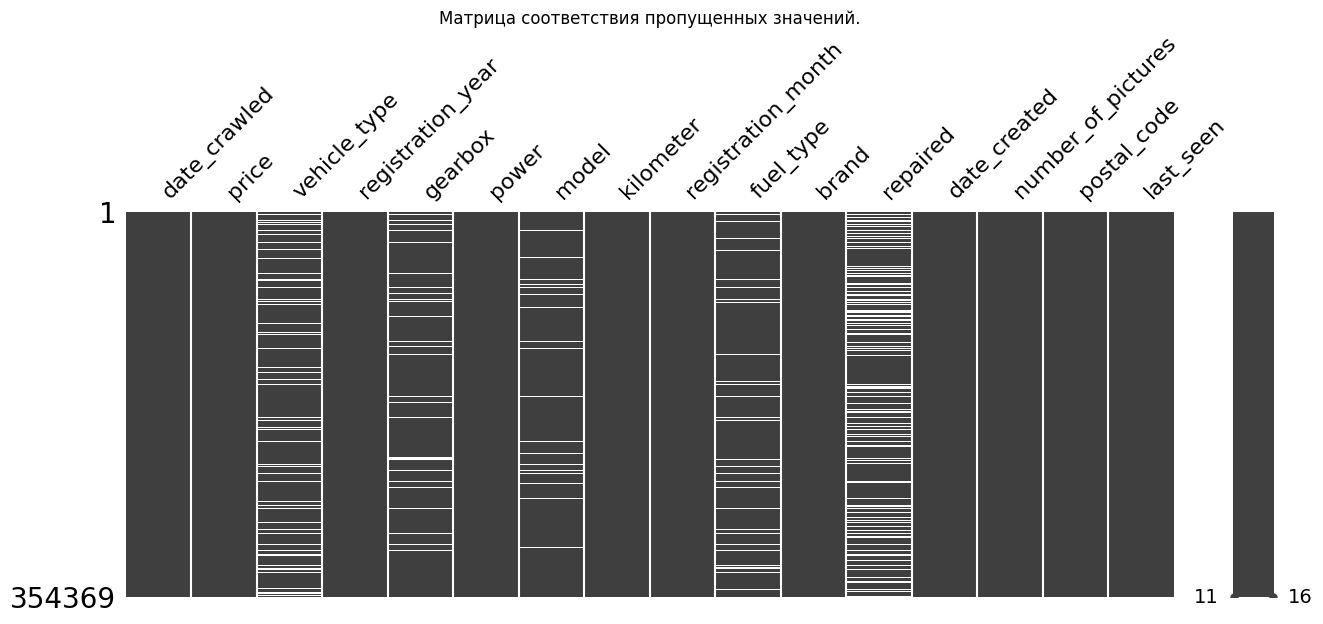



 
 Информация о составе датафрейма. 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen   

None

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
Асимметрия распределения:,1.43,74.62,60.16,-1.72,0.08,0.00,0.08
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.000000,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.000000,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000,1067.000000
5%,200.000000,1992.000000,0.000000,40000.000000,0.000000,0.000000,9569.000000
10%,499.000000,1995.000000,0.000000,70000.000000,0.000000,0.000000,14959.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.000000,71083.000000


,date_crawled,vehicle_type,gearbox,model,fuel_type,brand,repaired,date_created,last_seen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


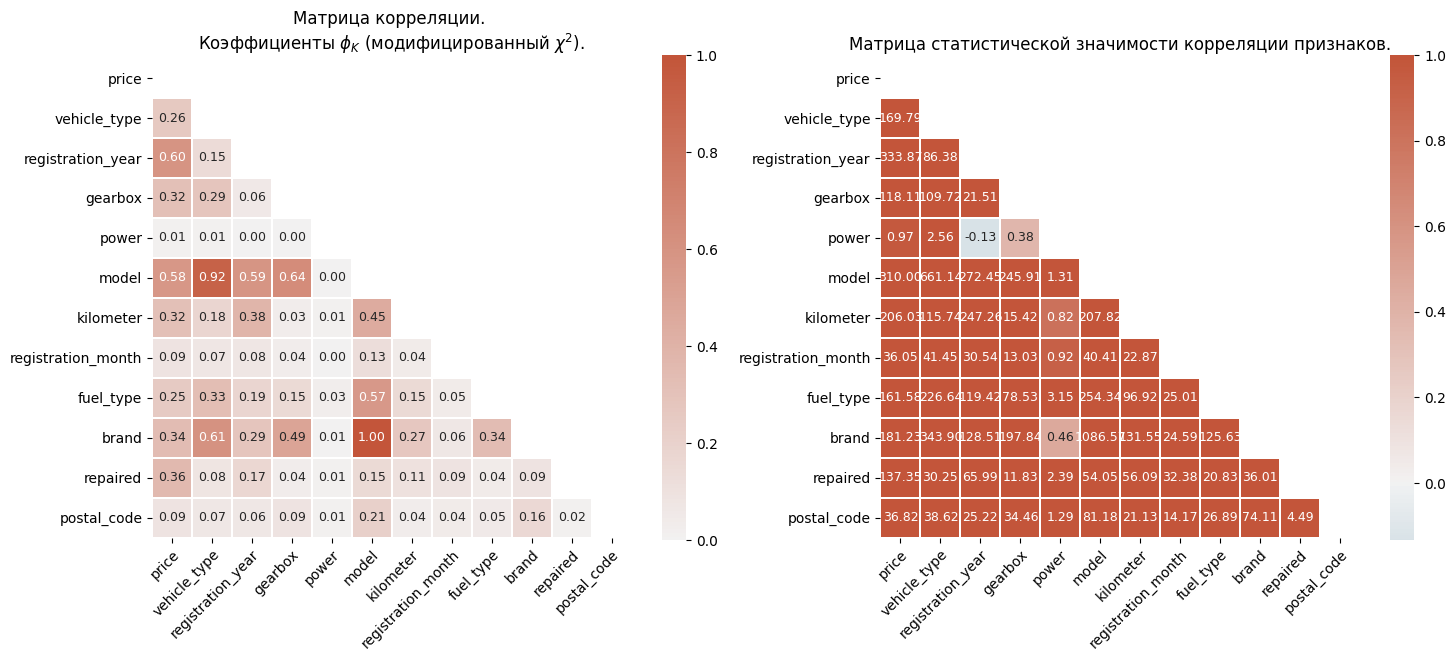

In [17]:
# Вызовем функции и выведем информацию о данных и о корреляции признаков.
get_eda_data(df, 'Характеристики подержанных автомобилей')
get_phik_data(df
              .drop(['date_crawled', 'date_created',
                       'last_seen', 'number_of_pictures'], axis=1)
              .dropna())

### Ознакомление, ИАД. Промежуточные выводы.
- В признаках `price` и `power` обнаружены аномальные значения, которые необходимо исключить при построении графиков.
- Аномальные значения будут обработаны в разделе ["Предобработка данных."](#Предобработка-данных.)

### Вывод графиков ИАД.

- Сгруппируем признаки для визуализации:
  - признаки для столбчатых диаграмм и диаграмм размаха по целевому признаку;
  - численные признаки.
- Вызовем функцию и выведем графики, исключив удаляемые аномальные значения, обнаруженные в признаках
  - `price` - исключим нулевые значения;
  - `power` - исключим нулевые значения и значения мощности более 500 л.с. <br>(порог выбран с превышением мощности "стандартных" седанов и кроссоверов в 2-4 раза).
- Отдельно выведем графики по признакам
  - `model`;
  - `registration_year`;
  - `registration_month`.

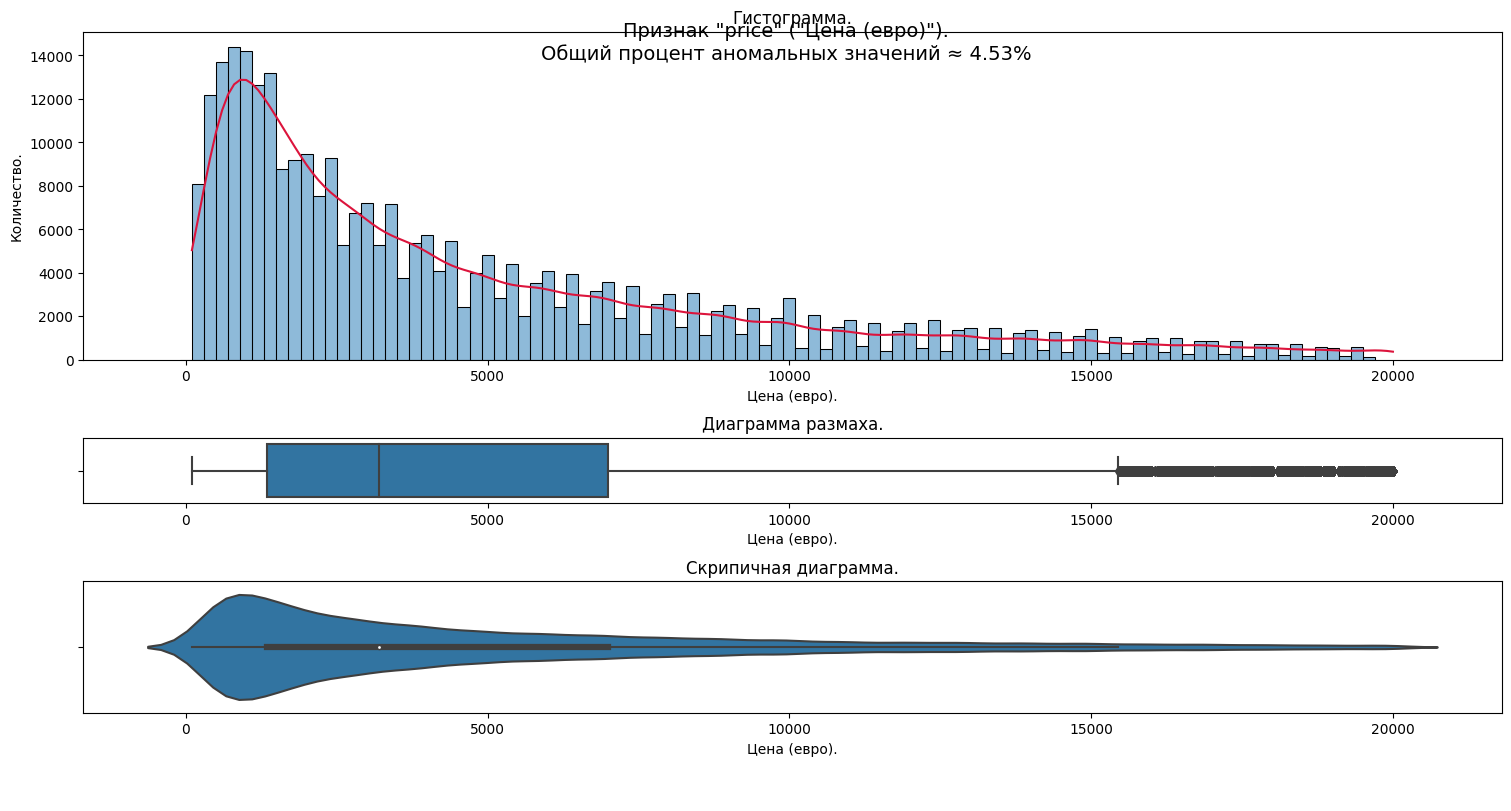

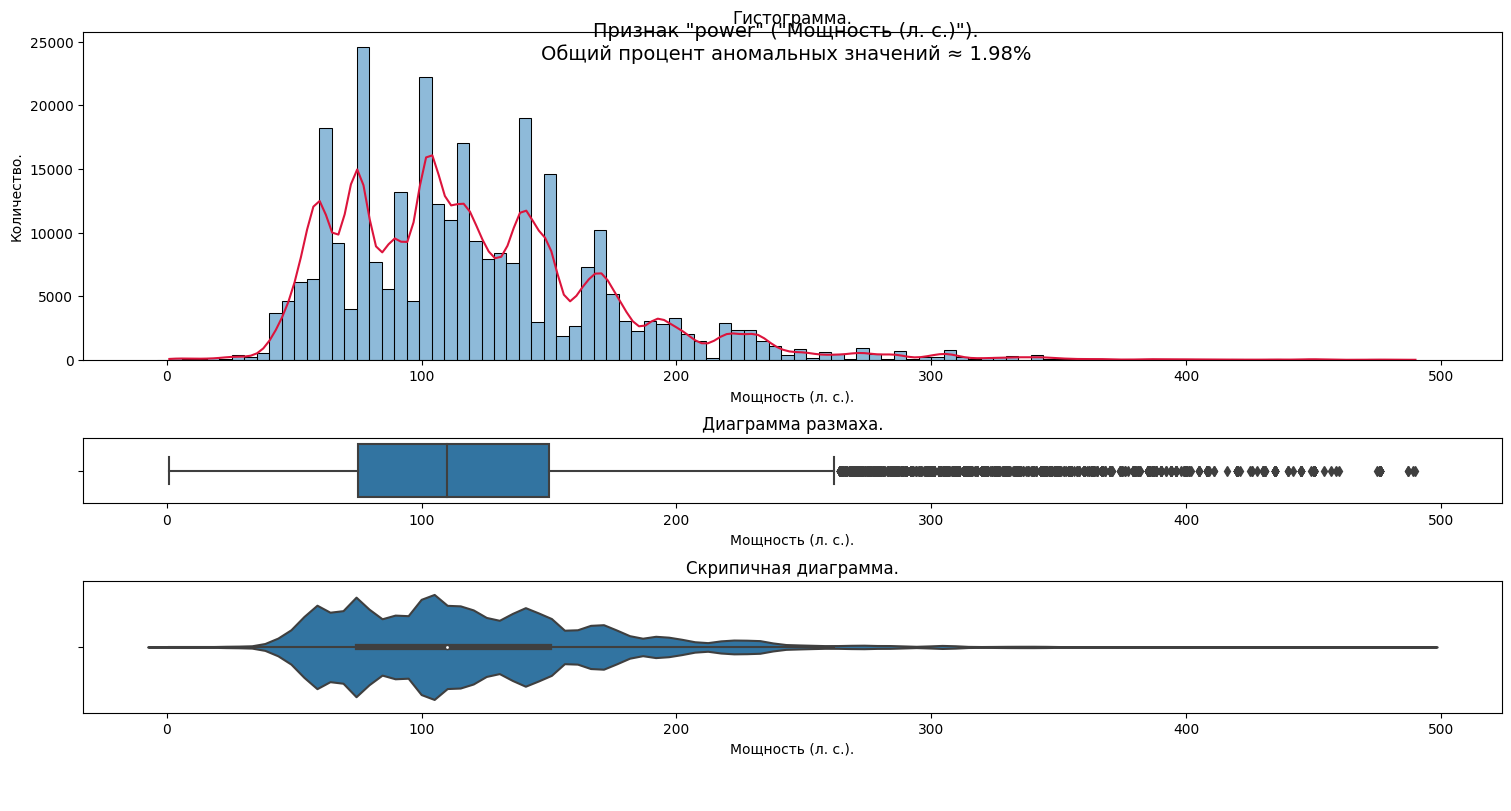

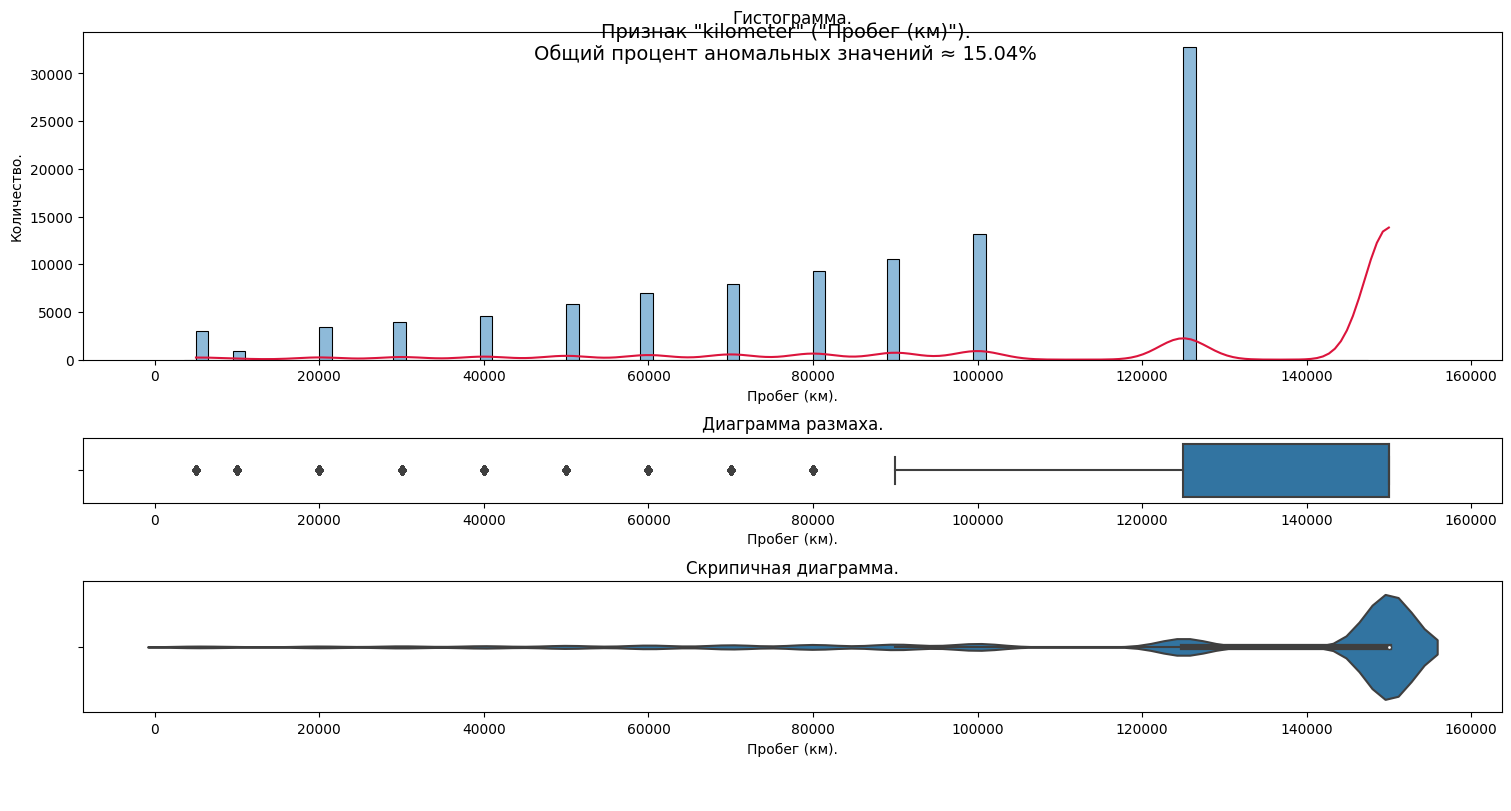

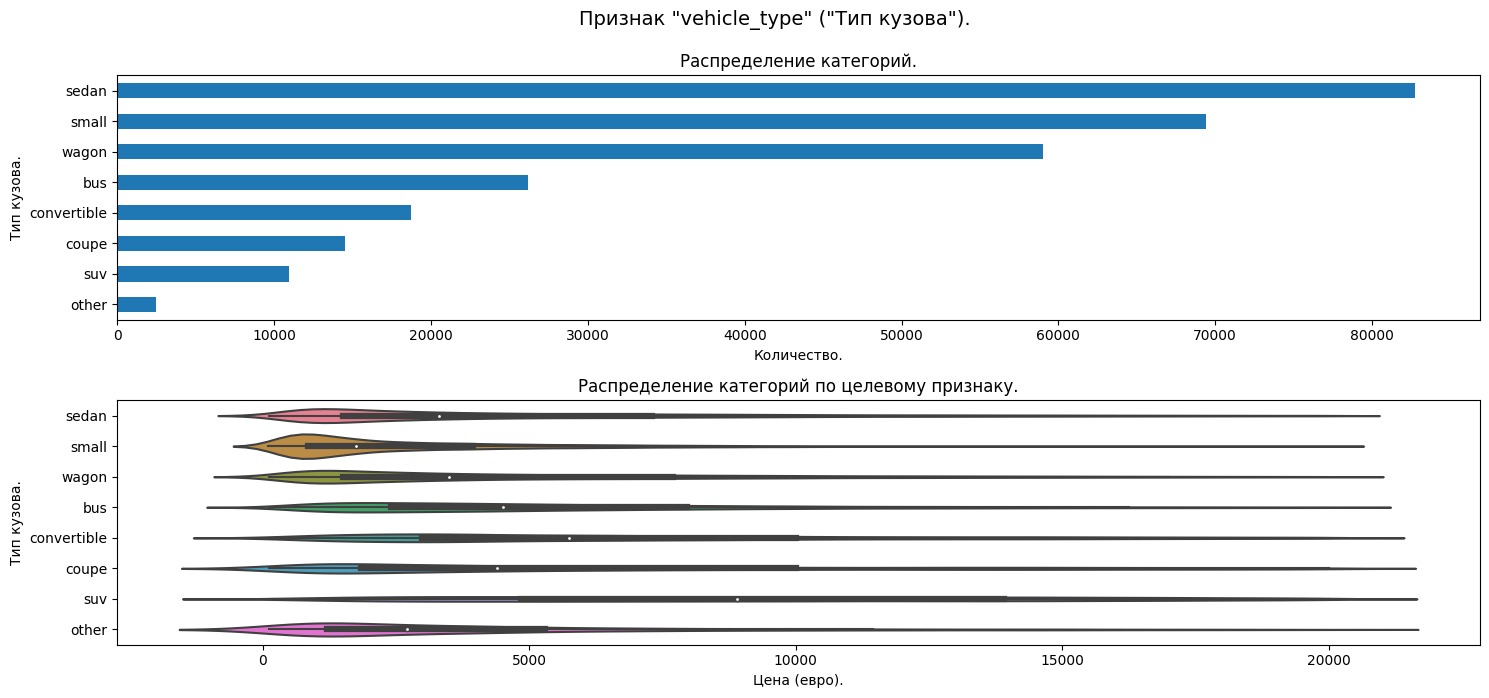

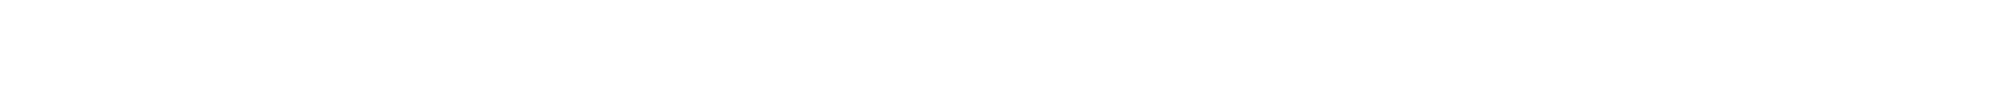

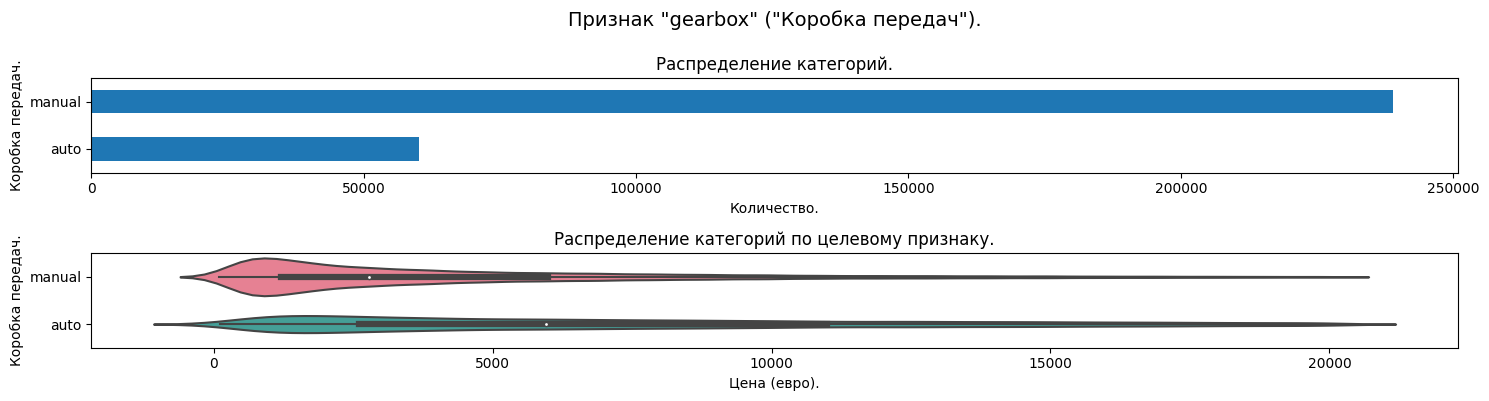

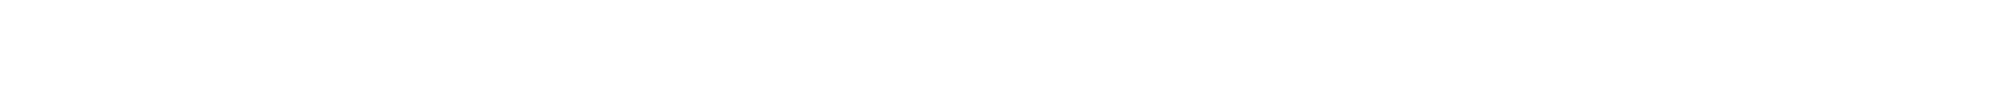

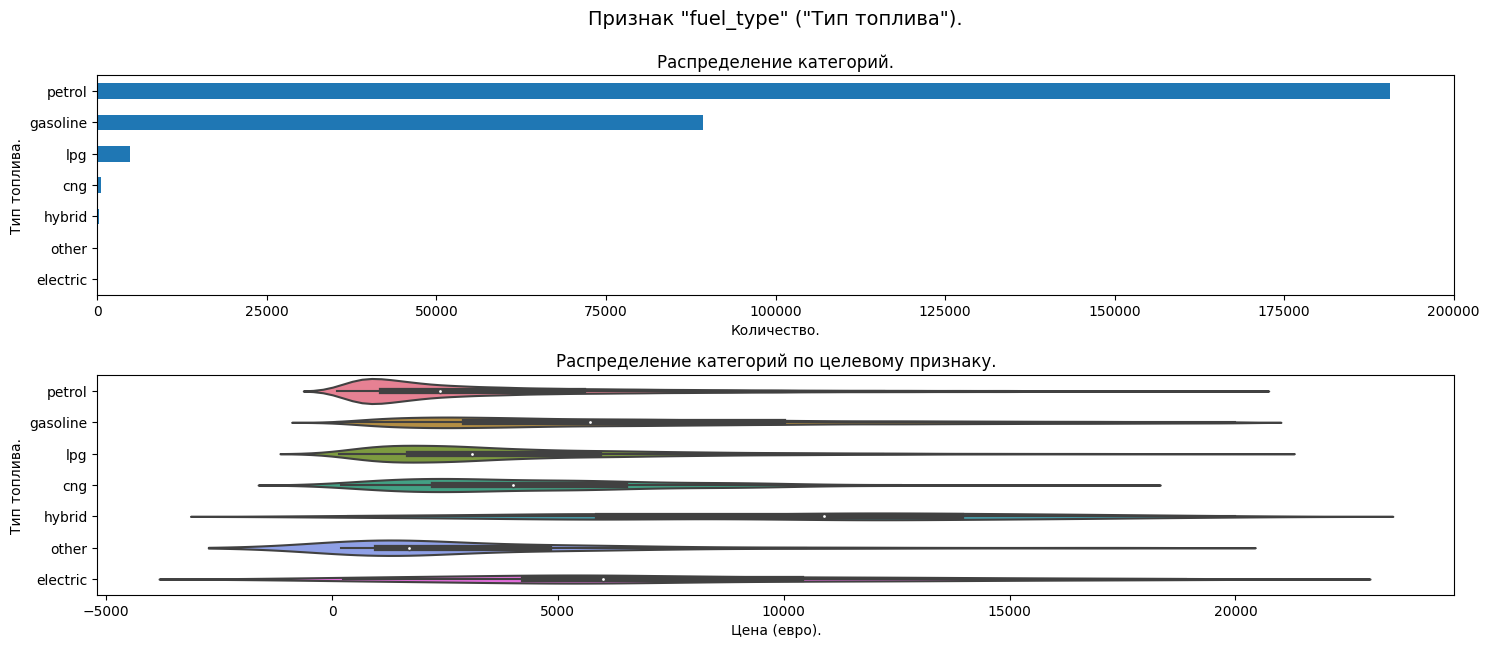

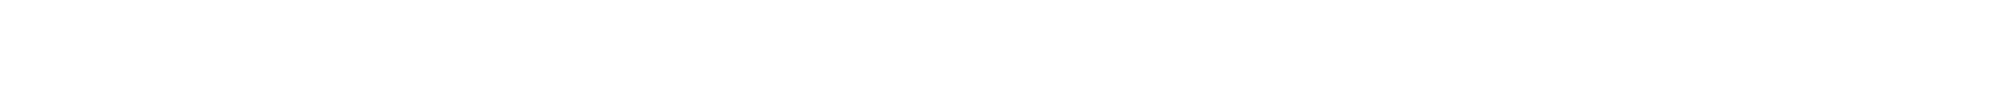

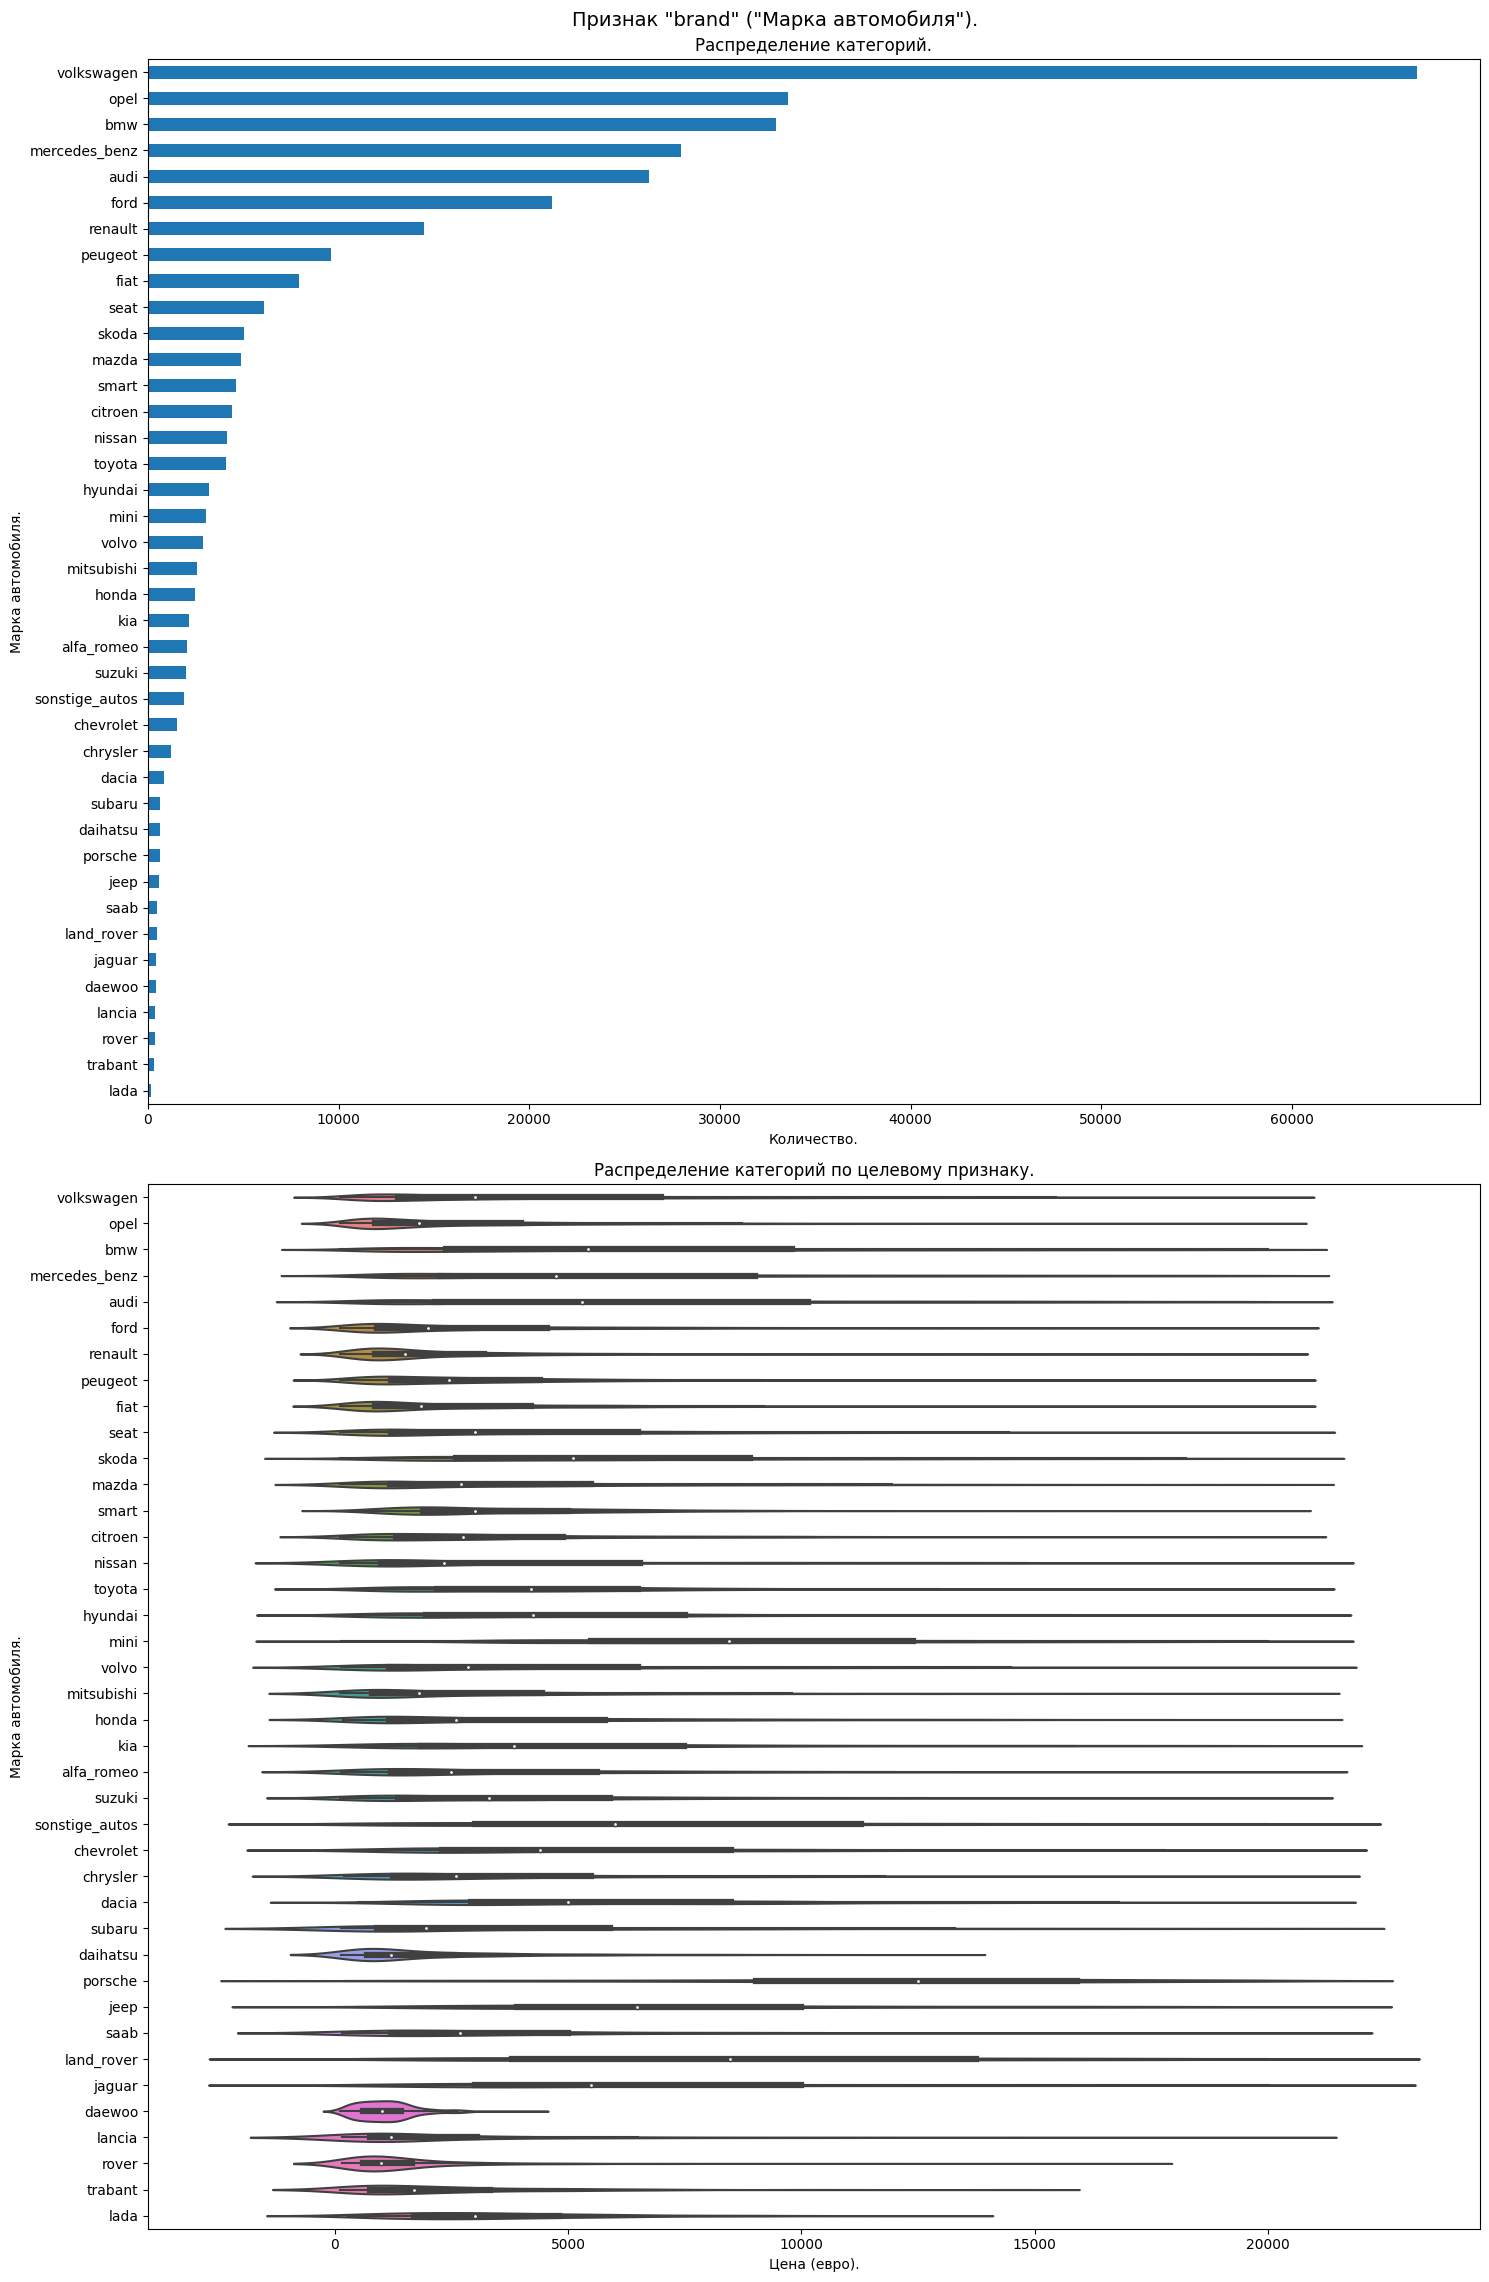

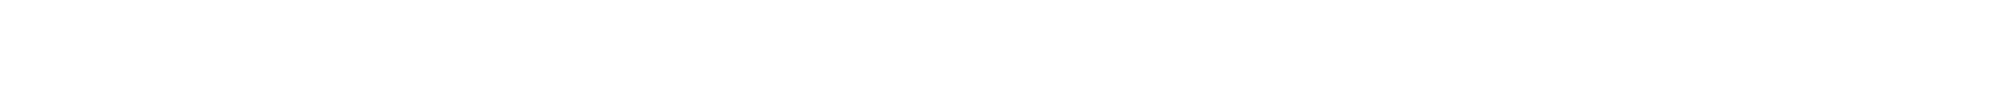

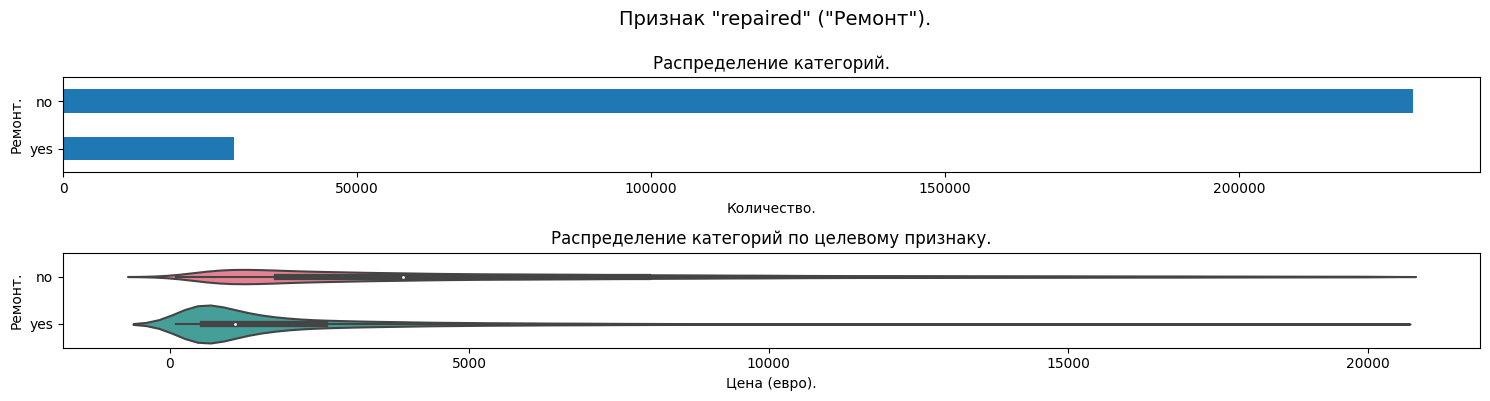

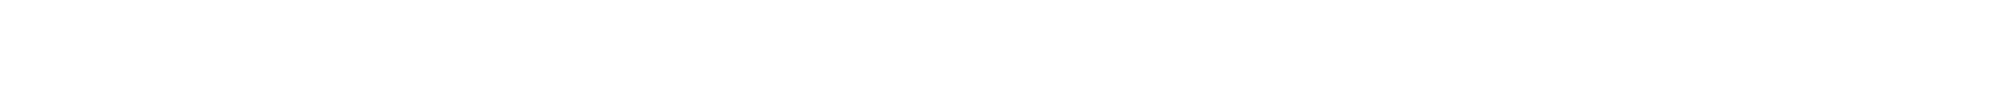

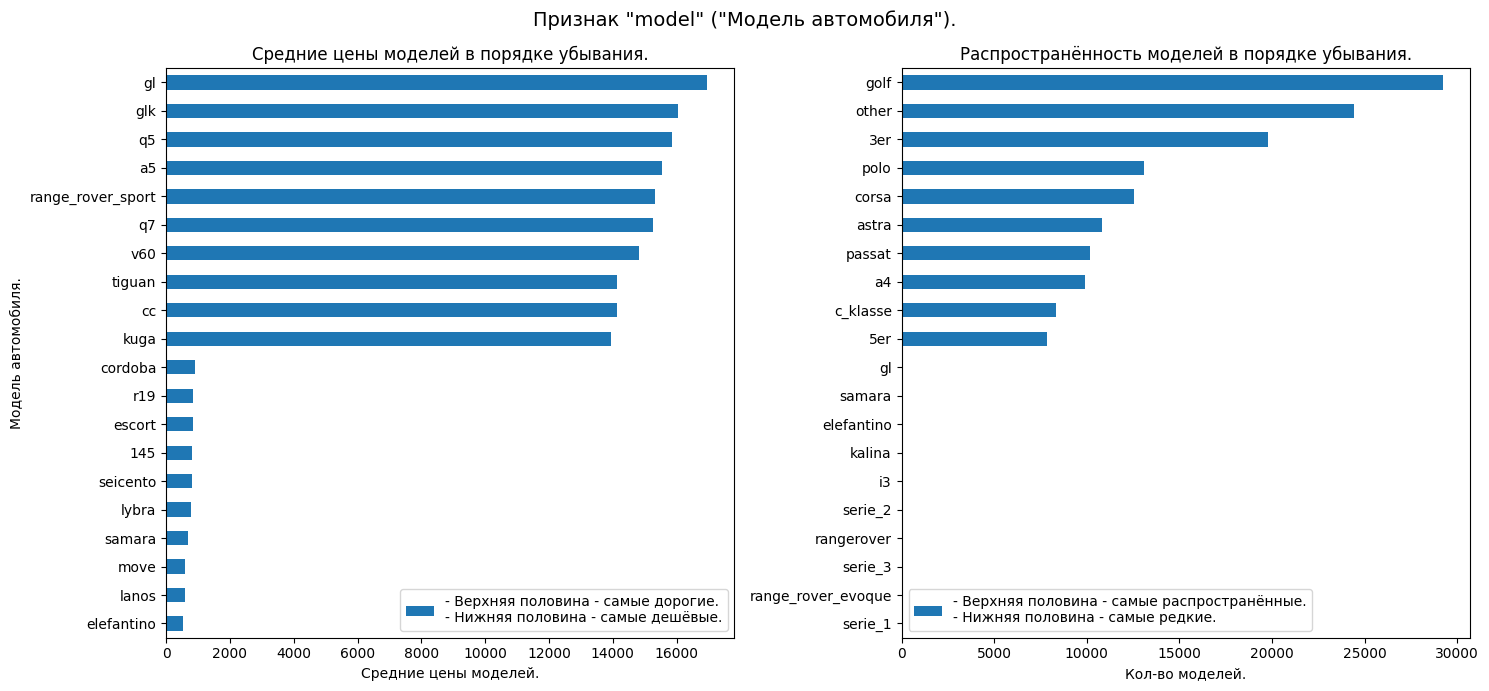

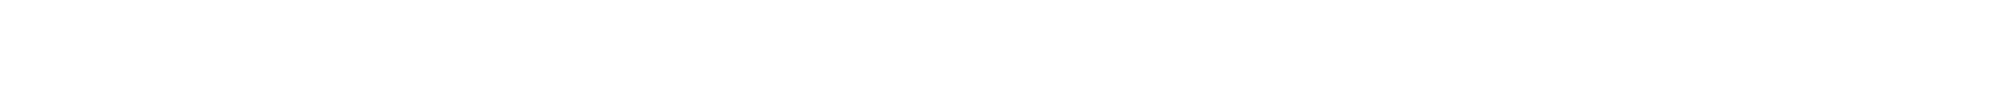

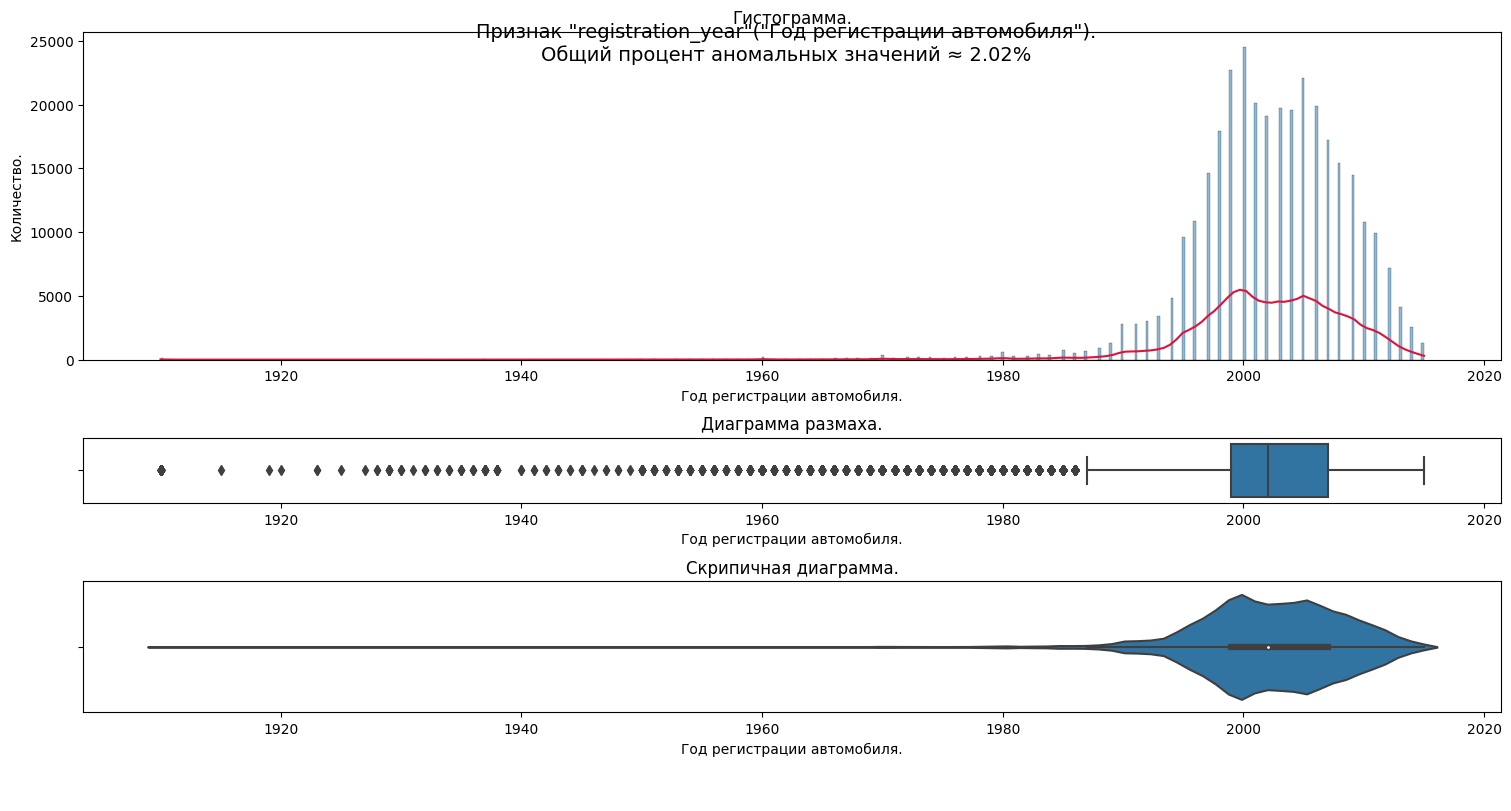

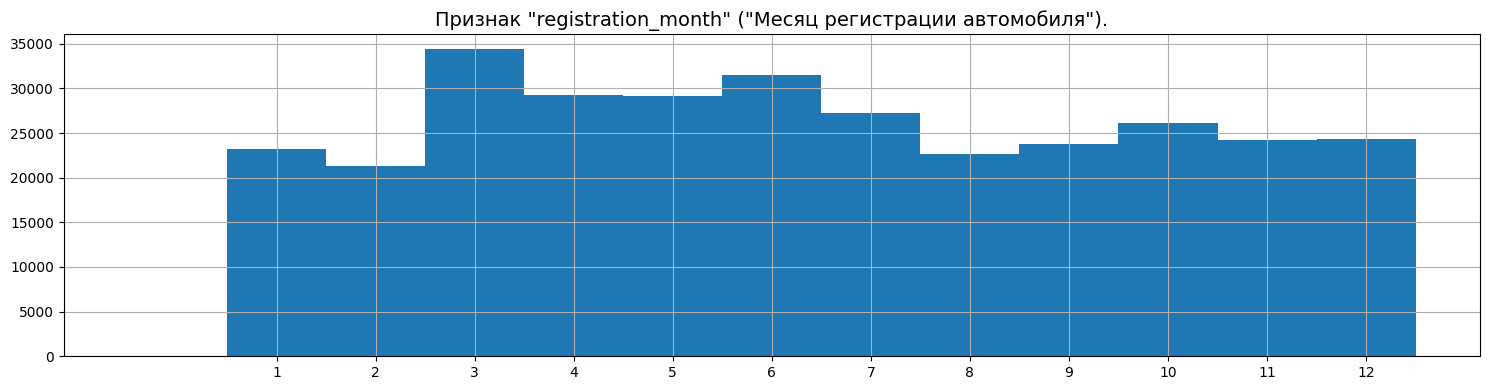

In [33]:
# Признаки для столбчатых диаграмм и диаграмм размаха по целевому.
cat_cols_wbox = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']
# Численные признаки.
num_cols = ['price', 'power', 'kilometer']

# Выведем графики для численных и некоторых категориальных признаков.
get_eda_plot(df.query('price > 100 and power > 0 and power < 500'),
             num_cols=num_cols,
             cat_cols_wbox=cat_cols_wbox,
             target='price')

# Выведем графики по признаку model.
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle(f'Признак "model" ("{col_names["model"]}").', fontsize=14)
# Выведем самые дорогие/дешёвые модели автомобилей.
(df
 .groupby('model')['price']
 .mean()
 .astype('int')
 .sort_values()
 .iloc[np.r_[0:10, -10:0]]
 .plot
 .barh(ax=axes[0]))
axes[0].legend(['- Верхняя половина - самые дорогие.\n- Нижняя половина '+
                '- самые дешёвые.'])
axes[0].set_title('Средние цены моделей в порядке убывания.')
axes[0].set_xlabel('Средние цены моделей.')
axes[0].set_ylabel(f'{col_names["model"]}.')
# Выведем самые популярные/непопулярные среди пользователей модели автомобилей.
(df
 .model
 .value_counts(ascending=True)
 .iloc[np.r_[0:10, -10:0]]
 .plot
 .barh(ax=axes[1]))
axes[1].legend(['- Верхняя половина - самые распространённые.\n- Нижняя '+
                'половина - самые редкие.'])
axes[1].set_title('Распространённость моделей в порядке убывания.')
axes[1].set_xlabel('Кол-во моделей.')
plt.tight_layout()
plt.show();

# Разделитель.
sep, ax = plt.subplots(1,1, figsize=(20, 1))
ax.axis('off')
plt.tight_layout()
plt.show();

# Построим графики для 'registration_year'.
reg_year = df.query('registration_year < 2016 and registration_year > 1900')
reg_year_col = 'registration_year'
fig = plt.figure(constrained_layout=True, figsize=(15, 8))
gs = fig.add_gridspec(4, 1, height_ratios=[5, 1, 2, .5])
fig.suptitle(f'Признак "{reg_year_col}"'+
             f'("{col_names[reg_year_col]}").' +
            '\nОбщий процент аномальных значений' +
            f' ≈ {get_outliers_ratio(reg_year, reg_year_col):.2%}',
                fontsize=14, x=.52)
# Гистограмма.
f_ax1 = fig.add_subplot(gs[0])
sns.histplot(data=reg_year,
             x=reg_year_col, kde=True)
f_ax1.lines[0].set_color('crimson')
f_ax1.set_title('Гистограмма.')
f_ax1.set_xlabel(f'{col_names[reg_year_col]}.')
f_ax1.set_ylabel(f'{col_names["ytitle"]}.')
# Диаграмма размаха.'
f_ax2 = fig.add_subplot(gs[1], sharex=f_ax1)
sns.boxplot(data=reg_year, x=reg_year_col)
f_ax2.set_title('Диаграмма размаха.')
f_ax2.set_xlabel(f'{col_names[reg_year_col]}.')
# Скрипичная диаграмма.
f_ax4 = fig.add_subplot(gs[2], sharex=f_ax1)
sns.violinplot(data=reg_year, x=reg_year_col)
f_ax4.set_title('Скрипичная диаграмма.')
f_ax4.set_xlabel(f'{col_names[reg_year_col]}.')
# Разделитель.
f_ax5 = fig.add_subplot(gs[3])
f_ax5.axis('off')
plt.show();

# Построим графики для 'registration_month'.
(df
 .loc[df['registration_month'] > 0,
      'registration_month']
 .hist(figsize=(15,4), bins=np.arange(14)-.5))
plt.title('Признак "registration_month" '+
          f'("{col_names["registration_month"]}").', fontsize=14)
plt.xticks(np.arange(1, 13, 1))
plt.tight_layout()
plt.show();

### Вывод дополнительной информации.
- Признак `date_created`:
  - Выведем кол-ва созданных объявлений по годам и месяцам, чтобы определить необходимость учёта временных интервалов и трендов и, в общем, определить ценность признака.
- Признак `date_crawled`:
  - Выведем последнюю дату скачивания базы данных. Анкеты, созданные после этой даты, не могли попасть в датасет, следовательно эта дата будет верхним пределом рассматриваемых значений признака `registration_year`.

- Признак `last_seen`:
  - Выведем годы, представленные в признаке, чтобы оценить ценность признака.

- Выведем кол-ва уникальных типов кузова по моделям для проверки гипотезы о том, что одной модели может соответствовать только один тип кузова.

- Выведем и проверим уникальные значения всех, кроме модели (`model`), категориальных признаков, не связанных с датой/временем:
  - `vehicle_type`;
  - `gearbox`;
  - `kilometer`;
  - `fuel_type`;
  - `brand`;
  - `repaired`.
- Признак `registration_year`.
  - Выведем 10 объектов с годом регистрации 1950.
- Выведем 20 первых строк среза с аномальными значениями цены (`price`) ниже 100 евро.

In [34]:
# Выведем доп. данные по признаку date_created.
print('\033[1mПризнак `date_created`.\033[0m')
print('Количества созданных анкет по годам:')
display(pd.to_datetime(df['date_created']).dt.year.value_counts())
print('\nКоличества созданных анкет по месяцам:')
display(pd.to_datetime(df['date_created']).dt.month.value_counts())
print('\n', '~' * 70, '\n')

# Выведем  доп. данные по признаку date_crawled.
print('\033[1mПризнак `date_crawled`.\033[0m')
print('Дата последнего скачивания базы данных: '+
      f'\n{df["date_crawled"].max()}.')
print('\n', '~' * 70, '\n')

# Выведем  доп. данные по признаку last_seen.
print('\033[1mПризнак `last_seen`.\033[0m\nГоды, представленные в '+
      'признаке "Последняя активность пользователя": '+
      f'\n{int(pd.to_datetime(df.last_seen).dt.year.unique())}')
print('\n', '~' * 70, '\n')

# Выведем общий процент объектов с пропусками.
print('\033[1mОбщий процент объектов с пропусками\033[0m: '+
      f'{((df.shape[0] - df.dropna().shape[0]) / df.shape[0]):.2%}.')
print('\n', '~' * 70, '\n')

# Выведем сводку по объектам с аномалиями.
print('\033[1mСводка по аномальным значениям.\033[0m')
print('Количество объектов с ценой менее 100 евро: '+
      f'{(price_err := sum(df["price"] < 100))}.')
print('- ' * 10)
print('Кол-во объектов с мощностью 0: '+
      f'{(power_err := sum(df["power"] == 0))}')
print('Кол-во объектов с мощностью более 500: '+
      f'{(power_err := sum(df["power"] > 500))}')
print('Кол-во объектов с нулевым значением мощности и присутствующим '+
      'названием модели авто.: '+
      f'{df.query("power == 0 and model.notna()").shape[0]}')
print('- ' * 10)
print('Объектов с нулевыми значениями в признаке "registration_month": '+
      f'{(regm_err := sum(df["registration_month"] == 0))}.')
print('Кол-во объектов до 1950 и и после 2016: ',
      (regy_err := sum(sum([(df['registration_year'] == 2016) &\
               (df['registration_month'] > 3) |\
               (df['registration_year'] > 2016) &\
               (df['registration_year'] < 1950)]))))

print('Общий процент аномальных значений: '+
      f'{(price_err + power_err + regm_err + regy_err) / df.shape[0]:.0%}')
print('\n', '~' * 70, '\n')

# Кол-ва типов кузова по моделям'
print('Кол-ва типов кузова по моделям')
df.groupby('model')['vehicle_type'].nunique()[:10]
print('\n', '~' * 70, '\n')

# Выведем уникальные значения признаков.
for col in ['vehicle_type', 'gearbox', 'kilometer',
            'fuel_type', 'brand', 'repaired']:
    print(f'\033[1mПризнак `{col}`.\033[0m\nУникальные значения:')
    display(str(list(df[col].unique())).strip("'[]"))
    print('\n', '~' * 70, '\n')

# Выведем 20 сэмплов со значениями цены ниже 100 евро.
display(df[df['price'] < 100]
        .head(20)
        .style
        .set_caption('20 сэмплов со значениями цены ниже 100 евро.')
        .set_table_styles(styles))

# Выведем 10 объектов с годом регистрации до 1987.
(df[df['registration_year'] < 1950]
 .head(10)
 .style
 .set_caption('10 сэмплов с годом регистрации до 1987.')
 .set_table_styles(styles))

Признак `date_created`.
Количества созданных анкет по годам:


2016    354343
2015        25
2014         1
Name: date_created, dtype: int64


Количества созданных анкет по месяцам:


3     296759
4      57119
2        397
1         70
11         9
12         9
9          3
8          2
6          1
Name: date_created, dtype: int64


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Признак `date_crawled`.
Дата последнего скачивания базы данных: 
2016-04-07 14:36:58.

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Признак `last_seen`.
Годы, представленные в признаке "Последняя активность пользователя": 
2016

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Общий процент объектов с пропусками: 30.63%.

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Сводка по аномальным значениям.
Количество объектов с ценой менее 100 евро: 13314.
- - - - - - - - - - 
Кол-во объектов с мощностью 0: 40225
Кол-во объектов с мощностью более 500: 459
Кол-во объектов с нулевым значением мощности и присутствующим названием модели авто.: 33931
- - - - - - - - - - 
Объектов с нулевыми значениями в признаке "registration_month": 37352.
Кол-во объектов до 1950 и и после 2016:  5362
Общий процент аномальных значений: 16%

 ~~~~~~~~~~~~~~~~~~

"nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other"


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Признак `gearbox`.
Уникальные значения:


"manual', 'auto', nan"


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Признак `kilometer`.
Уникальные значения:


'150000, 125000, 90000, 40000, 30000, 70000, 5000, 100000, 60000, 20000, 80000, 50000, 10000'


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Признак `fuel_type`.
Уникальные значения:


"petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric"


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Признак `brand`.
Уникальные значения:


"volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai', 'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia', 'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo', 'porsche', 'rover', 'land_rover', 'lada"


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Признак `repaired`.
Уникальные значения:


"nan, 'yes', 'no"


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,nan,1990,nan,0,corsa,150000,1,petrol,opel,nan,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,nan,150000,11,nan,sonstige_autos,nan,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,nan,2017,manual,0,golf,5000,12,petrol,volkswagen,nan,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,nan,0,nan,5000,0,petrol,volkswagen,nan,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
154,2016-03-22 16:37:59,0,nan,2006,nan,0,other,5000,0,nan,fiat,nan,2016-03-22 00:00:00,0,44867,2016-04-06 06:17:56
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,nan,ford,nan,2016-03-16 00:00:00,0,57627,2016-03-26 11:17:50
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11 00:00:00,0,55122,2016-03-26 23:15:49


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,nan,0,ka,5000,0,petrol,ford,nan,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
622,2016-03-16 16:55:09,0,nan,1111,nan,0,nan,5000,0,nan,opel,nan,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25 00:00:00,0,58135,2016-03-25 15:58:21
2273,2016-03-15 21:44:32,1800,convertible,1925,nan,0,nan,5000,1,nan,sonstige_autos,no,2016-03-15 00:00:00,0,79288,2016-04-07 05:15:34
6629,2016-04-02 13:47:16,0,small,1910,nan,0,nan,5000,1,other,sonstige_autos,nan,2016-04-02 00:00:00,0,93105,2016-04-04 11:16:30
6977,2016-03-24 08:37:22,135,nan,1910,nan,0,nan,5000,0,nan,opel,nan,2016-03-24 00:00:00,0,19374,2016-04-06 20:46:08
10183,2016-03-27 13:59:08,1250,nan,1910,nan,0,other,5000,0,nan,audi,nan,2016-03-27 00:00:00,0,18445,2016-04-07 10:45:31
16062,2016-03-29 23:42:16,190,nan,1000,nan,0,mondeo,5000,0,nan,ford,nan,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
16635,2016-03-09 10:54:11,9500,suv,1941,manual,57,nan,40000,1,petrol,sonstige_autos,no,2016-03-09 00:00:00,0,59557,2016-03-12 21:16:29
18023,2016-03-24 08:57:13,1,nan,1910,nan,0,nan,5000,0,nan,volkswagen,nan,2016-03-24 00:00:00,0,50829,2016-04-06 22:45:09


### Ознакомление, ИАД. Выводы.
#### Информация о составе данных.
- Датасет представлен 354369 записями и 16 признаками:
  - 3 признака формата дата/время;
  - 9 категориальных признака;
  - 4 количественных признака, включая целевой.
- Следующие признаки не несут информации, необходимой для построения моделей, и будут удалены в разделе [предобработки данных](#Предобработка-данных.):
    - `date_crawled` | дата скачивания анкеты:
      - не содержит информации для построения моделей;
    - `date_created` | дата создания анкеты:<br>
      - т.к. одинаковые (по любым причинам) объявления, созданные в разные даты только усложнят работу модели;
      - т.к. для двух из трёх представленных лет, информативно представлен только 2016г.;
    - `number_of_pictures` |   количество фотографий автомобиля:
      -  т.к. признакне содержит информации.
- Типы признаков приведены, за исключением признаков в формате дата/время, которые будут удалены.

#### Целевой признак.
- Целевой признак количественный, непрерывный.<br>

#### Задача машинного обучения.
- Т.к. целевой признак определен, количественный, непрерывный, задача построения предиктивной модели сводится к регрессионному анализу, "обучению с учителем".<br>

#### Аномалии в данных.
- Признак `price`.
  - Минимальное значение - `0`. <br>
  Необходимо удалить записи с нулевыми и аномальными значениями цены. За аномальные примем значения менее `100` евро, которые в данных с большой вероятностью являются ошибочно введёнными.
- Признак `power`.
  - Т.к. мощность у модификаций одной модели автомобиля, если и будет различаться, то  несильно, заменим ошибочные значения более 500 л.с. и нулевые медианным значением по модели.
- Признак `registration_year`.
  - Аномально низкие (`1000`) и высокие (`9999`) значения.<br>
   - Удалим записи с датой регистрации позже `03.2016`, т.к. анкеты, созданные позже не могли попасть в датасет, а определить верную дату не представляется возможным.
   - Удалим записи с годом регистрации до `1950` и при появлении такого маловероятнгого запроса будем давать ошибку, т.к.
     - автомобили, произведённые ранее единичны, а до ~1940г. все значения, скорее всего, ошибочны;
     - точность предсказания модели снизится, а время обучения увеличится.
- Признак `registration_month`.<br>
Нулевые значения месяца.
  - Удалим признак, т.к. обновление модели в год выпуска крайне маловероятно и обычно модели не обновляются в период от 3 до 8 лет.

#### Пропуски в данных.
> ___Примечание 1:___ &nbsp;&nbsp;
  - __Неосмысленное заполнение пропусков и аномальных значений "заглушкой"модой/медианой/средним/случайным/предыдущими/последующими приведёт к искажению данных и снижению качества модели.__
  - __Т.к. клиенту важны качество и скорость предсказания модели, рекомендуем введение обязательных для заполнения полей и конечных списков для выбора характеристик автомобиля, т.к. минимизация пропусков путём сбора качественных данных представляется более эффективной стратегией, чем__
    - __снижающая точность импутация случайными и пр. значениями;__
    - __снижающая точность, ресурсо- и времязатратная импутация с помощью алгоритмов МО (e.g. множественная импутации MICE).__
<br><br>

- Общий процент объёктов с пропусками ~ 31%. <br>
Данных, не учитывая пропуски и аномалии, достаточно для обучения моделей. <br>
- Признак `model`: тип пропусков - `MCAR`.
  - Удалим пропуски и рекомендуем сделать выбор модели автомобиля обязательным, т.к.
    - корреляция с признаком `brand` не означает каузацию и предсказать модель по марке невозможно;
    - заполнение самыми частыми значениями по марке исказит данные;
    - пропусков относительно немного ~ 5%.<br>
- Признак `vehicle_type`: тип пропусков - `MAR`/`MCAR`.<br>
  Пропуски необходимо удалить, т.к.
  - замена пропусков на значение `other` может исказить данные, т.к. значение может означать, например, модификацию кузова.
  - точное заполнение на основании марки и модели невозможно, т.к. в пределах одной марки и модели автомобиля тип кузова различается.
- Признак `gearbox`: тип пропусков - `MCAR`.
<br>Пропуски необходимо удалить, т.к. ни сильной корреляции ни смысловой связи с другими признаками установить не удалось (на одной модели коробка передач может различаться).
- Признак `fuel_type`: тип пропусков - `MCAR` <br>
Пропуски необходимо удалить, т.к. тип топлива одной модели автомобиля может отличаться в зависимости от разных лет выпуска или модификаций.
- Признак `repaired`: тип пропусков - `MCAR`. <br>
Пропуски необходимо удалить т.к.причинами пропусков могут быть
    - нежелание владельцев указывать проведение ремонта, снижая цену;
    - пропуск параметра владельцами, которые не ремонтировали автомобиль.
 <br><br>


#### Дубликаты в данных.
- Обнаружено 4 явных дубликата, которые будут удалены в разделе [предобработки данных](#Предобработка-данных.).
- Признак `power`: обнаружен смысловой дубликат.<br>
Заменим `petrol` на `gasoline`, т.к. эти значения полностью идентичны по смыслу.


#### Корреляция признаков / мультиколлинеарность.
- Обнаружена мультиколлинеарность пар признаков
  - `model` / `vehicle_type`;
  - `model` / `brand`.<br>
  Необходимо определить важность признаков для модели линейной регрессии и удалить/преобразовать парный.
<br><br>

-----------------------------------------------------------------------
#### Анализ признаков.

- Целевой признак `price`:
  - Распределение ненормально, имеет положительную ассиметрию.
  - Высокое стандартное отклонение (~`4514` евро), скорее всего, осложнит работу алгоритмов.
    - Возможно удаление выбросов или трансформация распределения, например квантильная.
  - Относительно небольшое кол-во уникальных значений непрерывного количественного признака вместе с повторяющимся рисунком в распределении значений могут говорить о синтетической природе данных и/или о временной зависимости, которую не представляется возможным определить по имеющимся данным.
- Признак `power`.
  - Распределение ненормально с сильной положительной ассиметрией.
  - Корреляция с целевым и другими признаками отсутствует.
- Признак `kilometer`.
  - Распределение признака показывает, что автомобилей с пробегом за 100 тыс.км. больше, чем остальных вместе.
- "Портрет" типичного автомобиля на платформе (признаки `vehicle_type`, `gearbox`, `fuel_type`, `repaired`, `brand` и `model`).
  - Наиболее распространены автомобили со следующими характеристиками:
	- тип кузова - седан и малые авто;
	- коробка передач - механическая;
	- тип топлива - бензин;
	- марка и модель - Volkswagen Golf.
  - Наиболее дорогие автомобили имеют следующие характеристики:
    - тип кузова - кроссовер;
	- коробка передач - автоматическая;
	- тип топлива - гибридный;
	- марка - Porsche и Land Rover;
	- модель - Mercedes-Benz GL.
- Признаки `registration_year`.
  - Присутствует небольшая корреляция с целевым признаком.
- Признак `postal_code`.
  - Признак мог бы быть полезен, т.к. цена автомобиля может меняться в зависимости от нас. пункта. Но, т.к. страна не определена, представляется возможным только проверить корреляцию после трансформации целевого признака, и при её отсутствии удалить признак.
  


## Подготовка данных.

### Обработка аномалий.


#### Признак `price`.
- Удалим объекты с нулевыми и аномальными значениями цены. <br>
За аномальные примем значения менее `100` евро, т.к. большинство цен в анкетах с такими значениями невалидны.
- Проверим результат.


In [35]:
# Удалим объекты с ценой менее 100 евро и проверим рез-тат.
df.drop(df[df['price'] < 100].index, axis=0, inplace=True)
print('Количество объектов с ценой менее 100 евро после удаления: '+
      f'{sum(df["price"] < 100)}.')
print(f'\nУдалено объектов: {del_counter - df.shape[0]}.')
del_counter -= (del_counter - df.shape[0])

Количество объектов с ценой менее 100 евро после удаления: 0.

Удалено объектов: 13314.


#### Признак `power`.
- __ВЕРСИЯ 2:__ Нулевые значения могут означать отсутствие двигателя. Оставим их без изменений.
- Заменим значения более 500 л.с. медианным значением по модели для имеющихся моделей и удалим остальные объекты.
- Проверим результат.

In [37]:
# Заменим значения более 500 л.с. и нулевые медианным значением по модели.
# df.loc[(df['power'] == 0) | (df['power'] > 500), 'power'] = np.nan
df.loc[df['power'] > 500, 'power'] = np.nan
df['power'].fillna(df.groupby('model')['power'].transform('median'),
                   inplace=True)

# Удалим оставшиеся объекты.
df.dropna(subset=['power'], inplace=True)

# Проверим рез-тат.
# print('Кол-во объектов с мощностью 0 и более 500 после удаления: '+
#       f'{sum(df["power"] == 0) + sum(df["power"] > 500)}')
print('Кол-во объектов с мощностью более 500 после удаления: '+
      f'{sum(df["power"] > 500)}')
print(f'\nУдалено объектов: {del_counter - df.shape[0]}.')
del_counter -= (del_counter - df.shape[0])

Кол-во объектов с мощностью более 500 после удаления: 0

Удалено объектов: 49.


#### Признак `registration_year`:
- Удалим записи с датой регистрации позже `03.2016`, т.к. анкеты, созданные позже не могли попасть в датасет и .
- Удалим записи с годом регистрации до `1950`, т.к. автомобили, произведённые ранее, скорее находятся в музеях.
- Проверим результат.

In [38]:
# Удалим записи с датой регистрации до 1950 и позже 03.2016.
df.drop(
    df.loc[(df['registration_year'] == 2016) &\
           (df['registration_month'] > 3) |\
           (df['registration_year'] > 2016) &\
           (df['registration_year'] < 1950)].index,
    axis=0,
    inplace=True
    )

print('Кол-во объектов в условном срезе после удаления: ',
      sum(sum([(df['registration_year'] == 2016) &\
               (df['registration_month'] > 3) |\
               (df['registration_year'] > 2016) &\
               (df['registration_year'] < 1950)])))

print(f'\nУдалено объектов: {del_counter - df.shape[0]}.')
del_counter -= (del_counter - df.shape[0])

Кол-во объектов в условном срезе после удаления:  0

Удалено объектов: 5044.


### Удаление неинформативных признаков.

#### Функция удаления признаков.
Создадим функцию удаления признаков с проверкой на явные дубликаты после каждого удаления.
- Функция примет датафрейм и названия признаков, которые необходимо удалить;
- Функция проверит наличие явных дубликатов перед удалением признаков и после каждогот удадения.
- Функция вернет датафрейм без удалённых признаков.

In [39]:
# Функция удаления признаков с проверкой на явные дубликаты.
def drop_cols(data: pd.DataFrame(), cols):
    '''
    Drops feature(s) with exact duplicates check.
    Prints out exact duplicates number for each new resulting dataframe after
    every iteration.
    Prints out the total of deleted features and names of features in the
    resulting dataset.
    Returns original dataset without dropped fetures.
    - Arguments:
    - data: pd.DataFrame(). Dataset to drop the feature(s) from.
    - cols: str | list. Name or names of features to drop.
    '''

    # Проверим входные данные.
    cols = [cols] if isinstance(cols, str) else cols

    # Запишем начальное кол-во признаков.
    ORIGINAL_SHAPE = data.shape

    # Выведем начальные данные.
    print(f'Начальное кол-во признаков: {ORIGINAL_SHAPE[1]}.')
    print('Начальное кол-во явных дубликатов: '+
          f'{data.duplicated().sum()}.\n------')

    # Удалим признаки, выводя прирост дубликатов.
    for col in cols:
        exact_dupl = data.duplicated().sum()
        data.drop(col, axis=1, inplace=True)
        exact_dupl = data.duplicated().sum() - exact_dupl
        print(f'Удалён признак "{col}". Прирост явных дубликатов после '+
            f'удаления: {exact_dupl}.\n-----')

    # Выведем результат работы и итоговый датафрейм.
    print('Общее кол-во явных дубликатов в финальном датафрейме: '
          f'{data.duplicated().sum()}.')
    print(f'Удалено признаков: {ORIGINAL_SHAPE[1] - data.shape[1]}. \nСписок '+
          'признаков после удаления:')
    display(str(list(data.columns)).strip("'[]"))

    return data

- Вызовем функцию и удалим признаки, не несущие информации необходимой для построения моделей:
  - `date_crawled`;
  - `registration_month`;
  - `date_created`;
  - `number_of_pictures`;
  - `last_seen`.
  

In [40]:
# Удалим признаки и проверим результат.
df = drop_cols(df, ['date_crawled', 'registration_month',
                    'date_created', 'number_of_pictures',
                    'last_seen'])

Начальное кол-во признаков: 16.
Начальное кол-во явных дубликатов: 4.
------
Удалён признак "date_crawled". Прирост явных дубликатов после удаления: 84.
-----
Удалён признак "registration_month". Прирост явных дубликатов после удаления: 7.
-----
Удалён признак "date_created". Прирост явных дубликатов после удаления: 1.
-----
Удалён признак "number_of_pictures". Прирост явных дубликатов после удаления: 0.
-----
Удалён признак "last_seen". Прирост явных дубликатов после удаления: 22303.
-----
Общее кол-во явных дубликатов в финальном датафрейме: 22399.
Удалено признаков: 5. 
Список признаков после удаления:


"price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'postal_code"

#### Удаление признаков. Вывод.
- Было удалено 5 неинформативных признаков, каждый из которых являлся источником явных дубликатов для каждого из сокращённых датафреймов:
  - `date_crawled`;
  - `registration_month`;
  - `date_created`;
  - `number_of_pictures`;
  - `last_seen`.
- Признак `last_seen` маскировал наибольшее кол-во дубликатов и в будущем должен быть удалён до любых операций с датасетом.
- Признак `postal_code` будет обработан в разделе ["Тестирование базовых моделей."](#Тестирование-базовых-моделей.)

### Обработка дубликатов.
- Удалим явные дубликаты.
- Заменим смысловой дубликат `petrol` в признаке ___ВЕРСИЯ2___:`fuel_type` на `gasoline`, т.к. эти значения полностью идентичны по смыслу.
- Проверим результат.

In [41]:
# Удалим явные дубликаты.
df.drop_duplicates(inplace=True)
print(f'Явных дубликатов после удаления: {df.duplicated().sum()}.')
print(f'\nУдалено объектов: {del_counter - df.shape[0]}.')
del_counter -= (del_counter - df.shape[0])

# Заменим petrol на gasoline.
df['fuel_type'] = df['fuel_type'].where(df['fuel_type'] != 'petrol', 'gasoline')
print('\nУникальные значения признака `fuel_type` после замены:')
display(str(list(df['fuel_type'].unique())).strip("'[]"))

Явных дубликатов после удаления: 0.

Удалено объектов: 22399.

Уникальные значения признака `fuel_type` после замены:


"gasoline', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric"

### Обработка пропусков.
- Удалим пропуски в признаках
  - `model`;
  - `vehicle_type`;
  - `gearbox`;
  - `fuel_type`;
  - `repaired`.
- Проверим результат.
- Проверим сохранены ли категории после удаления объектов.

In [42]:
# Удалим пропуски и проверим результат.
df.dropna(inplace=True)

print(f'\nУдалено объектов: {del_counter - df.shape[0]}.')
del_counter -= (del_counter - df.shape[0])
print(f'Кол-во пропусков в очищенном датафрейме: {df.isna().sum().sum()}')
print('\n' + '~' * 70 + '\n')

# Проверим сохранены ли категории после удаления объектов.
print('Сохранность категорий по признакам:')
preproc_nunique_per_col = {col : df[col].nunique() for col in df.columns}
preproc_nunique_per_col = {key : NUNIQUE_PER_COL[key] -\
                           preproc_nunique_per_col.get(key, 0)\
                           for key in preproc_nunique_per_col.keys()}
for k, v in preproc_nunique_per_col.items():
    if v >= 0:
        print(f'- признак "{k}" - категории сохранены.')
    else:
        print(f'- признак "{k}" - категории не сохранены. Кол-во потерь:', v)


Удалено объектов: 90073.
Кол-во пропусков в очищенном датафрейме: 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Сохранность категорий по признакам:
- признак "price" - категории сохранены.
- признак "vehicle_type" - категории сохранены.
- признак "registration_year" - категории сохранены.
- признак "gearbox" - категории сохранены.
- признак "power" - категории сохранены.
- признак "model" - категории сохранены.
- признак "kilometer" - категории сохранены.
- признак "fuel_type" - категории сохранены.
- признак "brand" - категории сохранены.
- признак "repaired" - категории сохранены.
- признак "postal_code" - категории сохранены.


#### Обработка пропусков. Вывод.
- После анализа явных пропусков, можно сделать вывод о том, что единственной осмысленной стратегией в данном случае является анализ полных данных с полным удалением пропусков.
- Было удалено все объекты с пропусками.

- Подведём итоги очистки данных.

In [43]:
print('Итого удалённых объектов: '+
      f'{(ORIGINAL_SHAPE[0] - df.shape[0]) / ORIGINAL_SHAPE[0]:.2%}')
print('Итого удалённых признаков: '+
      f'{ORIGINAL_SHAPE[1] - df.shape[1]}')

Итого удалённых объектов: 36.93%
Итого удалённых признаков: 5


### Предобработка данных. Вывод.
- Были частично заполнены и удалены аномальные значения и неявные пропуски.
- Были удалены неинформативные признаки.
- Были удалены явные дубликаты.
- Были полностью удалены явные пропуски.
- Признак `postal_code` будет обработан в разделе ["Тестирование базовых моделей."](#Тестирование-базовых-моделей.)

## Разделение на выборки.

#### Функция разделения на выборки.
- Разделим данные на обучающую, тренировочную и тестовую выборки.
- Проверим результат.

In [44]:
### Функция разделения на выборки с использованием train_test_split.
def tts_strat_split(data : pd.DataFrame,
                    target : str,
                    train_ratio : int or float,
                    val_ratio : int or float,
                    test_ratio: int or float,
                    stratify=False,
                    show_results=True):
    """
    Splits dataframe into train, test and optionally validation sets
    with or w/o stratification using test_train_split 1 or 2 times.
    If validation set is not required, input `val_ratio=0`.

    Parameters:
    - data: dataframe.
    - target: target column in quotes. Must be binary.
    - train_ratio, val_ratio, test_ratio: subset ratios. Must be same format :
    int or float.
    - stratify: bool.
    - show_results: bool.
    """
    # Зададим значения генератора псевдосл. чисел.
    np.random.seed(42)

    # Проверка формата целевого признака.
    if not isinstance(target, str) or target not in data.columns:
        raise ValueError('Датафрейм или название целевого признака ' +
                         'указаны неверно.\nПараметры функции: (датафрейм, ' +
                         '"целевой признак", размер обучающей выборки, ' +
                         'размер валидационной выборки (опционально), ' +
                         'размер тестовой выборки.).')

    # Запишем признаки в переменные.
    X = data.drop(target, axis=1)
    y = data[target]

    # Обработем доли, указанные в целочисленном формате.
    if sum([train_ratio, val_ratio, test_ratio]) == 10:
        train_ratio /= 10
        test_ratio /= 10
        val_ratio = 0 if val_ratio == 0 else val_ratio / 100

    elif sum([train_ratio, val_ratio, test_ratio]) == 100:
        train_ratio /= 100
        test_ratio /= 100
        val_ratio = 0 if val_ratio == 0 else val_ratio / 100

    # Обработка долей, указанных как соотношение.
    elif train_ratio + val_ratio + test_ratio == 1.0:
        total = train_ratio + val_ratio + test_ratio
        train_ratio /= total
        val_ratio = val_ratio / total
        test_ratio /= total

    # Проверка соответствия суммы долей 1.
    if round(sum([train_ratio, val_ratio, test_ratio]), 1) != 1:
        raise ValueError('Введено неверное соотношение выборок.')

    ## Разделим данные с помощью функции train_test_split из sklearn.
    # Разделение без валидационной выборки.
    if val_ratio == 0:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=(1/(1-val_ratio)*test_ratio),
            random_state=SEED,
            stratify=(y if stratify == True else None)
            )

        # Сбросим индексы выборок.
        for sample in [X_train, y_train, X_test, y_test]:
            sample.reset_index(drop=True, inplace=True)

        # Запись данных и индекса для таблицы проверки.
        size_check = [data.drop(target, axis=1), X_train, X_test]
        balance_check = [data[target], y_train, y_test]
        index = ['Исходный датафрейм:', 'Обучающая выборка:',
                 'Тестовая выборка:']

    # Разделение с валидационной выборкой.
    else:
        X_t, X_val, y_t, y_val = train_test_split(
            X, y,
            test_size=val_ratio,
            random_state=SEED,
            stratify=(y if stratify == True else None)
            )

        X_train, X_test, y_train, y_test = train_test_split(
            X_t, y_t,
            test_size=(1/(1-val_ratio)*test_ratio),
            random_state=SEED,
            stratify=(y_t if stratify == True else None)
            )

        # Сбросим индексы выборок.
        for sample in [X_train, y_train, X_val, y_val, X_test, y_test]:
            sample.reset_index(drop=True, inplace=True)

        # Запись данных и индекса для таблицы проверки.
        size_check = [data.drop(target, axis=1), X_train, X_val, X_test]
        balance_check = [data[target], y_train, y_val, y_test]
        index = ['Исходный датафрейм:', 'Обучающая выборка:',
                    'Валидационная выборка:', 'Тестовая выборка:']

    if stratify:
        ## Выведем таблицу проверки размерностей классов.
        balance_list = []
        for i in range(len(balance_check)):
            balance_list.append(
                [size_check[i].shape[0],
                f'{(size_check[i].shape[0] / size_check[0].shape[0]):.1%}',
                size_check[i].shape[1]]
                )

        cols = ['Кол-во объектов.', 'Процент объектов.', 'Кол-во признаков.']
        display(
            pd.DataFrame(balance_list, columns=cols,
                        index=index)
                .style
                .set_caption('Результат разделения выборок.')
                .set_table_styles(styles)
        )

        class_data = (
            y_train
            .value_counts(normalize=True)
            .reset_index()
            )

        if val_ratio > 0:
             class_data = class_data.merge(y_val
                                           .value_counts(normalize=True)
                                           .reset_index(),
                                           on=target)

        class_data = (
            class_data
            .merge(y_test.value_counts(normalize=True).reset_index(),
                   on=target)
            )

        # Выведем проценты объектов по классам.
        ax = class_data.plot.barh()
        ax.bar_label(
            ax.containers[0],
            labels=list(class_data
                        .drop(target, axis=1)
                        .mean(axis=1)
                        .map('{:.2%}'.format))
            )
        ax.set_title('Проценты объектов по классам после разделения.\n'+
                     'Аннотации отображают средний процент.')
        if val_ratio != 0:
            ax.legend(['Обучающая', 'Валидационная', 'Тестовая'],
                      title='Выборки:')
        else:
            ax.legend(['Обучающая', 'Тестовая'], title='Выборки:')
        ax.xaxis.set_major_formatter(tick.PercentFormatter(xmax=1))
        ax.set_yticklabels(class_data[target])
        plt.show();
    else:
        ## Выведем таблицу проверки размерностей.
        balance_list = []
        for i in range(len(balance_check)):
            balance_list.append(
                [size_check[i].shape[0],
                f'{(size_check[i].shape[0] / size_check[0].shape[0]):.1%}',
                size_check[i].shape[1]]
            )

        cols = pd.MultiIndex.from_tuples([
            ('Кол-во объектов.', ''),
            ('Процент объектов.', ''),
            ('Кол-во признаков.', ''),
            ])

        display(
            pd.DataFrame(balance_list, columns=cols, index=index)
            .style
            .set_caption('Результат разделения выборок.')
            .set_table_styles(styles)
        )

    ## Выведем результирующие выборки.
    if val_ratio != 0:
        return (X_train, X_val, X_test, y_train, y_val, y_test)
    else:
        return (X_train, X_test, y_train, y_test)

#### Разделение на выборки.

In [45]:
# Разделим даннные на выборки.
(X_train, X_val, X_test,
 y_train, y_val, y_test) = tts_strat_split(df, 'price', .6, .2, .2)

,Кол-во объектов.,Процент объектов.,Кол-во признаков.
,,,
Исходный датафрейм:,223490,100.0%,10
Обучающая выборка:,134094,60.0%,10
Валидационная выборка:,44698,20.0%,10
Тестовая выборка:,44698,20.0%,10


## Базовые модели. Тестирование гипотез.
Установим параметры тестирования базовых моделей и зададим пайплайны обработки данных для всех алгоритмов.
- За базовые модели примем относительно быстрые алогоритмы из библиотеки `Sklearn`:
  - линейную регрессию `LinearRegression`
    - категориальные признаки закодируем методом прямого кодирования;
    - численные признаки смасштабируем;
  - градиентный бустинг на основе гистограмм `HistGradientBoostingRegressor`
    - категориальные признаки закодируем методом порядкового кодирования.
- С помощью базовых моделей протестируем три гипотезы:
  - улучшает ли признак `postal_code`  целевую метрику и/или время обучения/предсказания алгоритмов?
  - улучшает целевую метрику и/или время обучения/предсказания алгоритмов создание нового предиктора на основе двух с идеальной попарной корреляцией?
  - улучшает ли целевую метрику квантильное преобразование целевого признака?

### Определение параметров тестирования.
- Определим категориальные, количественные, целевой признаки и признак для проверки.
- Определим базовые алгоритмы с гиперпараметрами по умолчанию и целевой метрикой - `RMSE`.
- Определим базовую трансформацию признаков и пайплайны.
- Определим основную функцию обучения базовых моделей.

In [46]:
# Определим категориальные, количественные, целевой признаки и признак
# для проверки.
cat_cols = ['vehicle_type', 'gearbox', 'model',
            'fuel_type', 'brand', 'repaired']
num_cols = ['registration_year', 'power', 'kilometer', ]
check_col = ['postal_code']
target = 'price'

# Определим базовый трансформер распределения целевого признака.
qt = QuantileTransformer(n_quantiles=2000, output_distribution='normal',
                         random_state=SEED)

# Определим базовые алгоритмы.
lr = LinearRegression()
hgbr = HistGradientBoostingRegressor(random_state=SEED)

# Определим базовую трансформацию признаков и пайплайны для лин. регрессии.
col_trans_lr = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='error', drop='first'), cat_cols),
    ('scale', StandardScaler(), num_cols)
    ], n_jobs=-1)

lr_pipe = Pipeline(steps=[
    ('col_trans_lr', col_trans_lr),
    ('lr', lr)
    ])

lr_pipe_tt = TransformedTargetRegressor(regressor=lr_pipe, transformer=qt)

# Определим базовую трансформацию признаков и пайплайны для градиентного
# бустинга.
col_trans_boost = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(handle_unknown='error'), cat_cols),
    ], remainder='passthrough', n_jobs=-1)

hgbr_pipe = Pipeline(steps=[
    ('col_trans_boost', col_trans_boost),
    ('hgbr', hgbr)
    ])

hgbr_pipe_tt = TransformedTargetRegressor(regressor=hgbr_pipe, transformer=qt)

- Определим основную функцию обучения базовых моделей.

In [47]:
# Определим основную функцию обучения базовых моделей.
def lr_boost_predict(lr_pipe, boost_pipe,
                     X_t, y_t,
                     X_v, y_v,
                     return_data=False,
                     title=('Сравнение RMSE и времени '+
                            'обучения/предсказания моделей.')):

    # Линейная регрессия.
    lr_start = perf_counter() # Таймер.
    lr_pipe.fit(X_t, y_t)
    lr_stop = perf_counter() # Таймер.
    lr_train_t = lr_stop - lr_start

    lr_pred_start = perf_counter() # Таймер.
    rmse_lr = mean_squared_error(y_v, lr_pipe.predict(X_v),
                                squared=False)
    lr_pred_stop = perf_counter() # Таймер.
    lr_pred_t = lr_pred_stop - lr_pred_start

    # Градиентный бустинг.
    boost_start = perf_counter() # Таймер.
    boost_pipe.fit(X_t, y_t)
    boost_stop = perf_counter() # Таймер.
    boost_train_t = boost_stop - boost_start

    boost_pred_start = perf_counter() # Таймер.
    rmse_boost = mean_squared_error(y_v, boost_pipe.predict(X_v),
                                squared=False)
    boost_pred_stop = perf_counter() # Таймер.
    boost_pred_t = boost_pred_stop - boost_pred_start

    display(
        pd.DataFrame(
            {'Линейная регрессия.' :
             [round(rmse_lr, 2), round(lr_train_t, 2), round(lr_pred_t, 2)],
             'Градиентный бустинг.' :
              [round(rmse_boost, 2),
               round(boost_train_t, 2),
               round(boost_pred_t, 2)],},
            index=['RMSE:', 'Время обучения:', 'Время предсказания:'])
    .style
    .set_caption(title)
    .set_table_styles(styles)
    )

    if return_data:
        return (lr_pipe, rmse_lr, lr_train_t, lr_pred_t,
                rmse_boost, rmse_boost, boost_train_t, boost_pred_t)

#### Тестирование признака `postal_code`.
- Сравним целевую метрику `RMSE`
  - без учёта признака;
  - с его включением после кластеризации путём деления всех значений на 1000 и округления до целых (мин. значение = 1067).

In [48]:
# # Определим функцию трансформации.
def scale_by_1000(col):
    return pd.DataFrame(col / 1000).astype('int')

## Вычислим целевую метрику без postal_code.
col_trans_boost.transformers.append(('dropcol', 'drop', ['postal_code']))
lr_boost_predict(lr_pipe, hgbr_pipe, X_train, y_train, X_val, y_val,
                 title='Базовые модели.\nЦелевая метрика без "postal_code"')
col_trans_boost.transformers.pop(1)
## Добавим обработку postal_code в базовую трансформацию и вычислим
## целевую метрику.
for col_trans in [col_trans_lr, col_trans_boost]:
    col_trans.transformers.insert(
        1, ('reduce_dim', FunctionTransformer(scale_by_1000),
            'postal_code')
    )
print('\n')
lr_boost_predict(lr_pipe, hgbr_pipe, X_train, y_train, X_val, y_val,
                 title=('Базовые модели.\nЦелевая метрика с модиф. '+
                        '"postal_code"'))

for col_trans in [col_trans_lr, col_trans_boost]:
    col_trans.transformers.pop(1)

,Линейная регрессия.,Градиентный бустинг.
RMSE:,2639.880000,1697.290000
Время обучения:,3.530000,2.060000
Время предсказания:,0.990000,1.020000


,Линейная регрессия.,Градиентный бустинг.
RMSE:,2638.500000,1695.520000
Время обучения:,2.180000,1.090000
Время предсказания:,0.920000,0.200000


##### Тестирование признака `postal_code`. Вывод.
- `RMSE` в обоих случаях практически одинакова, но без признака обе модели более производительны.
- Удалим признак `postal_code` и проверим результат.

In [49]:
for data in [X_train, X_val, X_test]:
    data.drop('postal_code', axis=1, inplace=True)
    display(data.columns)

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

### Тестирование трансформации распределения целевого признака.
- Вычислим метрики после кватильной трансформации и снижения дисперсии целевого признака.

In [50]:
lr_pipe_tt.fit(X_train, y_train)
rmse_lr_tt = mean_squared_error(y_val, lr_pipe_tt.predict(X_val),
                                squared=False)
print(f'RMSE регресии: {round(rmse_lr_tt, 2)}.')
hgbr_pipe_tt.fit(X_train, y_train)
rmse_hgbr_tt = mean_squared_error(y_val, hgbr_pipe_tt.predict(X_val),
                                  squared=False)
print(f'RMSE градиентного бустинга: {round(rmse_hgbr_tt, 2)}.')

RMSE регресии: 2285.89.
RMSE градиентного бустинга: 1721.09.


#### Тестирование трансформации распределения целевого признака. Вывод.
- Линейная регрессия ожидаемо показала уменьшение значения целевой метрики `RMSE`, но недостаточное, чтобы конкурировать с градиентный бустингом.
- Метод неэффективен.

### Тестирование объединения `brand`, `model`.
Проверим улучшит ли целевую метрику и/или время обучения/предсказания алгоритмов создание нового предиктора на основе двух с идеальной корреляцией.
- Для этого создадим функцию, которая соединит строковые значения двух признаков в один новый признак и сбросит оригиналы.
- Проверим метрики с новым признаком.

In [51]:
# Функция,  соединяющая строковые значения 2 признаков.
def combine_and_remove(data):
    data['brand_model'] = (data['brand'] + ' ' +\
                           data['model']).str.strip()
    data.drop(['brand', 'model'], axis=1, inplace=True)

    return data

cols_to_merge = ['brand', 'model']
cat_cols_feat_gen = ['gearbox', 'fuel_type', 'repaired', 'brand_model',
                     'vehicle_type']

# Применим функцию к копии данных.
X_train_feat_gen = X_train.copy()
X_val_feat_gen = X_val.copy()

a = combine_and_remove(X_train_feat_gen[cols_to_merge])
b = combine_and_remove(X_val_feat_gen[cols_to_merge])
X_train_feat_gen.loc[:, 'brand_model'] = a
X_val_feat_gen.loc[:, 'brand_model'] = b

X_train_feat_gen.drop(['brand', 'model'], axis=1, inplace=True)
X_val_feat_gen.drop(['brand', 'model'], axis=1, inplace=True)

# Определим базовую трансформацию признаков и пайплайны для лин. регрессии.
col_trans_lr_feat_gen = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'),
     cat_cols_feat_gen),
    ('scale', StandardScaler(), num_cols)
    ], n_jobs=1)

lr_pipe_feat_gen = Pipeline(steps=[
    ('col_trans_lr_feat_gen', col_trans_lr_feat_gen),
    ('lr', lr)
    ])

# Определим базовую трансформацию признаков и пайплайны для градиентного
# бустинга.
col_trans_boost_feat_gen = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=500), cat_cols_feat_gen),
    ], remainder='passthrough', n_jobs=-1)

hgbr_pipe_feat_gen = Pipeline(steps=[
    ('col_trans_boost_feat_gen', col_trans_boost_feat_gen),
    ('hgbr', hgbr)
    ])

# Определим базовую трансформацию признаков и пайплайны для градиентного
# бустинга.
lr_boost_predict(lr_pipe_feat_gen, hgbr_pipe_feat_gen,
                 X_train_feat_gen, y_train, X_val_feat_gen, y_val,
                 title=('Базовые модели.\nЦелевая метрика с ген. произнака '+
                        'на основе "brand", "model"'))

,Линейная регрессия.,Градиентный бустинг.
RMSE:,2633.750000,1706.670000
Время обучения:,1.860000,1.110000
Время предсказания:,0.080000,0.200000


#### Тестирование объединения `brand` и `model`. Выводы.
- Линейная регрессия показала незначительный рост в целевой метрике, но сильно упала в длительности обучения.
- Градиентный бустинг изменений не показал.
- Метод неэфaективен. Далее исследуем различные модели градиентного бустинга.

## Обучение моделей.
- Для освобождения памяти удалим все "тяжёлые" временные переменные.
- Установим параметры обучения моделей.
- C помощью библиотеки `Optuna` найдём гиперпараметры минимизирующие `RMSE` для следующих моделей:
  - `DecisionTreeRegreessor`;
  - `HistGradientBoostingRegressor`;
  - `LightGradientBoostingMachineRegressor`;
  - `CatBoostRegessor`.

> Примечание: диапазоны значений гиперпараметров и количества испытаний `Optuna` сокращены до оптимальных, найденных с использованием GPU.

In [52]:
# Уалим все тяжёлые временные переменные.
del (X_train_feat_gen, X_val_feat_gen, hgbr_pipe_feat_gen,
     hgbr_pipe_tt, lr_pipe_feat_gen, lr_pipe_tt, data)

### Установка параметров обучения моделей.
- Создадим трансформер порядкового кодирования признаков.
- Создадим экземпляры классов и пайплайны моделей.
- Зададим уровень логирования `Optuna`.

In [53]:
# Создадим трансформер порядкового кодирования признаков.
col_enc = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value',
                               unknown_value=500), cat_cols)
        ], remainder='passthrough', n_jobs=-1
    )

# Создадим экземпляр класса и пайплайн DecisionTreeRegressor.
dtr = DecisionTreeRegressor(random_state=SEED)
dtr_pipe = Pipeline(steps=[('col_enc', col_enc),
                            ('dtr', dtr)])

# Создадим экземпляр класса и пайплайн HistGradientBoostingRegressor.
hgbr = HistGradientBoostingRegressor(random_state=SEED)
hgbr_pipe = Pipeline(steps=[('col_enc', col_enc),
                            ('hgbr', hgbr)])

# Создадим экземпляр класса и пайплайн модLGBMRegressorели.
lgbmr = LGBMRegressor(verbose=-1, random_state=SEED)
lgbmr_pipe = Pipeline(steps=[('col_enc', col_enc),
                            ('lgbmr', lgbmr)])

# Создадим экземпляр класса  пайплайн CatBoostRegressor.
cbr = CatBoostRegressor(silent=True, random_seed=SEED)
cbr_pipe = Pipeline(steps=[('col_enc', col_enc),
                            ('cbr', cbr)])

# Зададим уровень логирования Optuna.
optuna.logging.set_verbosity(optuna.logging.WARNING)

### Модель `DecisionTreeRegressor`.
Обучим модель с перебором гиперпараметров для минимизации `RMSE`.
- Создадим функцию `objective` в которой укажем гиперпараметры и метрику для оптимизации - `RMSE`.

In [54]:
# Создадим функцию.
def objective_dtr(trial):

    # Список гиперпараметров для LightGBM.
    hyperparams_dtr = {
        'dtr__max_depth' : trial.suggest_int('max_depth', 1, 20),
        }

    # Подберём параметры для минимизации RMSE.
    dtr_pipe.set_params(**hyperparams_dtr)
    dtr_pipe.fit(X_train, y_train)
    predictions = dtr_pipe.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse

- Создадим исследование и вызовем функцию оптимизации гиперпараметров.

In [55]:
%%time
# Создадим исследование и вызовем функцию оптимизации гиперпараметров.
study_dtr = optuna.create_study(direction='minimize', study_name='dtr')
study_dtr.optimize(objective_dtr, n_trials=20, show_progress_bar=True)
print('\n\033[1mАлгоритм - DecisionTreeRegressor.\033[0m')
print('\033[1mГиперпараметры лучшей модели:\033[0m')
display(study_dtr.best_params)
print(f'\033[1mМинимальная RMSE:\033[0m {round(study_dtr.best_value, 2)}\n')

  0%|          | 0/20 [00:00<?, ?it/s]


Алгоритм - DecisionTreeRegressor.
Гиперпараметры лучшей модели:


{'max_depth': 14}

Минимальная RMSE: 1913.7

CPU times: total: 6.47 s
Wall time: 13.9 s


### Модель `HistGradientBoostingRegressor`.
Обучим модель с перебором гиперпараметров для минимизации `RMSE`.
- Создадим функцию `objective` в которой укажем гиперпараметры и метрику для оптимизации - `RMSE`.

In [56]:
# Создадим функцию исследования Optuna.
def objective_hgbr(trial):

    # Определим список гиперпараметров.
    hyperparams_hgbr = {
        'hgbr__max_leaf_nodes' : trial.suggest_int('max_leaf_nodes',
                                                   85, 90),
        'hgbr__max_iter': trial.suggest_int('max_iter', 860, 900),
        'hgbr__learning_rate': trial.suggest_float('learning_rate',
                                                   .04, .06, log=True),
        }

    # Подберём параметры для минимизации RMSE.
    hgbr_pipe.set_params(**hyperparams_hgbr)
    hgbr_pipe.fit(X_train, y_train)
    predictions = hgbr_pipe.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse

- Создадим исследование и вызовем функцию оптимизации гиперпараметров.

In [57]:
%%time
# Создадим исследование и вызовем функцию оптимизации гиперпараметров.
study_hgbr = optuna.create_study(direction='minimize', study_name='hgbr')
study_hgbr.optimize(objective_hgbr, n_trials=10, show_progress_bar=True)
print('\n\033[1mАлгоритм - HistGradientBoostingRegressor.\033[0m')
print('\033[1mГиперпараметры лучшей модели:\033[0m')
display(study_hgbr.best_params)
print(f'\033[1mМинимальная RMSE:\033[0m {round(study_hgbr.best_value, 2)}\n')

  0%|          | 0/10 [00:00<?, ?it/s]


Алгоритм - HistGradientBoostingRegressor.
Гиперпараметры лучшей модели:


{'max_leaf_nodes': 86, 'max_iter': 884, 'learning_rate': 0.05072172860904421}

Минимальная RMSE: 1579.07

CPU times: total: 8min 34s
Wall time: 1min 31s


### Модель`LightGBM`.
Обучим модель с перебором гиперпараметров для минимизации `RMSE`.
- Создадим функцию `objective` в которой укажем гиперпараметры и метрику для оптимизации - `RMSE`.

In [58]:
# Создадим функцию исследования Optuna.
def objective_lgbmr(trial):

    # Определим список гиперпараметров.
    hyperparams_lgbmr = {
        'lgbmr__objective': 'regression',
        'lgbmr__metric': 'rmse',
        'lgbmr__num_leaves' : trial.suggest_int('num_leaves', 50, 150),
        'lgbmr__n_estimators': trial.suggest_int('n_estimators',
                                                 600, 800),
        'lgbmr__verbosity': -1,
        'lgbmr__learning_rate': trial.suggest_float('learning_rate',
                                                   1e-2, .1, log=True),
        'lgbmr__subsample': trial.suggest_float('subsample', .5, 1.0),
        }

    # Создадим экземпляр класса и пайплайн модLGBMRegressorели.
    lgbmr = LGBMRegressor(random_state=SEED)
    lgbmr_pipe = Pipeline(steps=[('col_enc', col_enc),
                                ('lgbmr', lgbmr)])

    # Подберём параметры для минимизации RMSE.
    lgbmr_pipe.set_params(**hyperparams_lgbmr)
    lgbmr_pipe.fit(X_train, y_train)
    predictions = lgbmr_pipe.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse

- Создадим исследование и вызовем функцию оптимизации гиперпараметров.

In [59]:
%%time
# Создадим исследование и вызовем функцию оптимизации гиперпараметров.
study_lgbmr = optuna.create_study(direction='minimize', study_name='lgbmr')
study_lgbmr.optimize(objective_lgbmr, n_trials=30, show_progress_bar=True)
print('\n\033[1mАлгоритм - LightGBM.\033[0m')
print('\033[1mГиперпараметры лучшей модели:\033[0m')
display(study_lgbmr.best_params)
print(f'\033[1mМинимальная RMSE:\033[0m {round(study_lgbmr.best_value, 2)}\n')

  0%|          | 0/30 [00:00<?, ?it/s]


Алгоритм - LightGBM.
Гиперпараметры лучшей модели:


{'num_leaves': 118,
 'n_estimators': 796,
 'learning_rate': 0.05778313858444973,
 'subsample': 0.8193577018633222}

Минимальная RMSE: 1568.2

CPU times: total: 10min 58s
Wall time: 2min


### Модель `CatBoostRegressor`.
Обучим модель с перебором гиперпараметров для минимизации `RMSE`.

In [60]:
# Создадим функцию исследования Optuna.
def objective_cbr(trial):

    # Определим список гиперпараметров.
    hyperparams_cbr = {
        'cbr__depth': trial.suggest_int('depth', 1, 15, 5),
        'cbr__learning_rate': trial.suggest_float('learning_rate',
                                                  .05, .1),
        'cbr__iterations': trial.suggest_int('iterations', 800, 1000, 100),
#         'cbr__task_type': 'GPU'
        }

    # Создадим экземпляр класса модели.
    cbr = CatBoostRegressor(silent=True, random_seed=SEED)
    # Создадим пайплайн.
    cbr_pipe = Pipeline(steps=[('col_enc', col_enc),
                               ('cbr', cbr)])

    # Подберём параметры для минимизации RMSE.
    cbr_pipe.set_params(**hyperparams_cbr)
    cbr_pipe.fit(X_train, y_train)
    predictions = cbr_pipe.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse

- Создадим исследование и вызовем функцию оптимизации гиперпараметров.

In [61]:
%%time
# Создадим исследование и вызовем функцию оптимизации гиперпараметров.
study_cbr = optuna.create_study(direction='minimize', study_name='cbr')
study_cbr.optimize(objective_cbr, n_trials=10, show_progress_bar=True)
print('\n\033[1mАлгоритм - CatBoostRegressor.\033[0m')
print('\033[1mГиперпараметры лучшей модели:\033[0m')
display(study_cbr.best_params)
print(f'\033[1mМинимальная RMSE:\033[0m {round(study_cbr.best_value, 2)}\n')

  0%|          | 0/10 [00:00<?, ?it/s]


Алгоритм - CatBoostRegressor.
Гиперпараметры лучшей модели:


{'depth': 11, 'learning_rate': 0.09910328227998849, 'iterations': 800}

Минимальная RMSE: 1578.92

CPU times: total: 16min 13s
Wall time: 2min 49s


## Анализ моделей.
- Для моделей с подобранными гиперпараметрами на валидационной выборке сравним
  - целевую метрику `RMSE` / качество предсказаний;
  - время обучения;
  - время предсказания;
  - важность признаков.

### Подготовка к сравнению моделей.
- Создадим экземпляр класса и пайплайн константного базового регрессора для определения адекватности итоговых моделей.
- Введём оптимальные подобранные гиперпараметры в пайплайны.
- Зададим функцию, которая
  - примет модель / пайплайн;
  - обучающую и тестовую выборки;
  - замерит и выведет время обучения и предсказания моделей;
  - выведет `RMSE`, `R2` и обученные модели.


In [62]:
# Создадим экземпляр класса и пайплайн константного регрессора.
dumdum = DummyRegressor()
dum_pipe = Pipeline(steps=[('col_enc', col_enc),
                           ('dum', dumdum)])

# Введём оптимальные гиперпараметры в модели.
dtr_pipe.set_params(dtr__max_depth=study_dtr.best_params['max_depth'])

hgbr_pipe.set_params(
    hgbr__max_leaf_nodes=study_hgbr.best_params['max_leaf_nodes'],
    hgbr__max_iter=study_hgbr.best_params['max_iter'],
    hgbr__learning_rate=study_hgbr.best_params['learning_rate'])

lgbmr_pipe.set_params(
    lgbmr__num_leaves=study_lgbmr.best_params['num_leaves'],
    lgbmr__n_estimators=study_lgbmr.best_params['n_estimators'],
    lgbmr__learning_rate=study_lgbmr.best_params['learning_rate'],
    lgbmr__subsample=study_lgbmr.best_params['subsample'])

cbr = CatBoostRegressor(silent=True, random_seed=SEED)
cbr_pipe = Pipeline(steps=[('col_enc', col_enc),
                               ('cbr', cbr)])
cbr_pipe.set_params(cbr__learning_rate=study_cbr.best_params['learning_rate'],
                    cbr__iterations=study_cbr.best_params['iterations'],
                    cbr__depth=study_cbr.best_params['depth'])

# Зададим функцию замера времени обучения и предсказания моделей и вывода RMSE.
def get_preds_timing(model, X_train, y_train, X_test, y_test):

    start = perf_counter() # Таймер.
    model.fit(X_train, y_train)
    stop = perf_counter() # Таймер.
    train_time = stop - start # Время обучения.

    start = perf_counter() # Таймер.
    preds = model.predict(X_test)
    stop = perf_counter() # Таймер.
    pred_time = stop - start # Время обучения.

    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    return [model, model[-1].__class__.__name__,
            rmse, r2, train_time, pred_time]

### Анализ моделей.
- Вызовем функцию для всех анализируемых моделей, обучим их и вычислим метрики на валидационной выборке.
  - Выведем таблицу производительности алгоритмов.
  - Выведем график важности некоторых признаков (исключим времязатратный  метод `permutation_importance` для алгоритма `HistGradientBoostingRegressor`).
- Выберем наилучшую.

  0%|          | 0/5 [00:00<?, ?it/s]

,Алгоритм,RMSE (евро),R2,Время обучения (cек.),Время предсказания (cек.)
2,LGBMRegressor,1568.199668,0.889697,3.729229,0.633201
3,CatBoostRegressor,1578.920901,0.888184,29.064316,0.259226
1,HistGradientBoostingRegressor,1579.067489,0.888163,9.104044,0.820967
0,DecisionTreeRegressor,1913.697903,0.835740,0.630883,0.098171
4,DummyRegressor,4721.951321,-0.000062,0.388374,0.089872


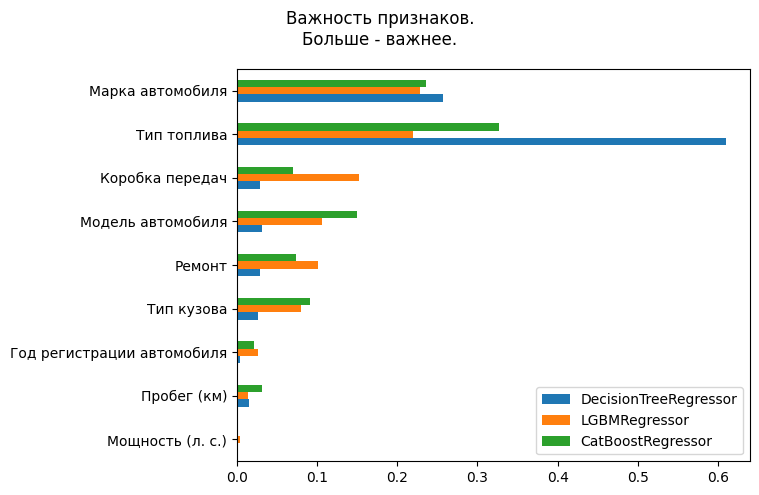

In [66]:
# Вызовем функцию и получим данные.
pipe_list = []
for pipe in tqdm([dtr_pipe, hgbr_pipe, lgbmr_pipe, cbr_pipe, dum_pipe]):
    pipe_list.append(get_preds_timing(pipe, X_train, y_train, X_val, y_val))
# Создадим сводную таблицу.
pipe_data = pd.DataFrame(pipe_list).iloc[:, 1:]
pipe_data.columns = ['Алгоритм', 'RMSE (евро)', 'R2',
                     'Время обучения (cек.)', 'Время предсказания (cек.)']

display(pipe_data
        .sort_values(by='RMSE (евро)')
        .style
        .set_caption('Производительность алгоритмов.')
        .set_table_styles(styles))
print('\n')
pd.DataFrame(
    {'DecisionTreeRegressor':
     pipe_list[0][0].named_steps['dtr'].feature_importances_,
     'LGBMRegressor':
     pipe_list[2][0].named_steps['lgbmr'].feature_importances_/100000,
     'CatBoostRegressor':
     pipe_list[3][0].named_steps['cbr'].feature_importances_/100},
    index=[col_names[col] for col in list(X_train.columns)]
    ).sort_values(by='LGBMRegressor').plot.barh(figsize=(7.7, 5))
plt.suptitle('Важность признаков.\nБольше - важнее.')
plt.tight_layout()
plt.show();

#### Анализ моделей. Вывод.
- Лучшая модель - LGBMRegressor.
  - Точность: наименьшее значение целевой метрики `RMSE`;
  - Время обучения: уступает только DecisionTreeRegressor, у которого `RMSE` гораздо выше.
  - Время предсказания: на уровне остальных моделей, кроме CatBoostReggressor, у которого выше `RMSE` и время обучениявыше на порядок.

### Тестрование финальной модели.
- Соединим обучающую и валидационную выборки для обучения лучшей модели с подобранными гиперпараметрами и тестирования на отложенной тестовой выборке.

In [68]:
# Соединим обучающую и валидационную выборки для финального тестирования.
X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([y_train, y_val])

# Вызовем функцию и получим данные.
final_pipe_list = (get_preds_timing(lgbmr_pipe, X_train_final, y_train_final, X_test, y_test))

# Занесём данные в таблицу.
final_pipe_data = pd.DataFrame(final_pipe_list).T.iloc[:, 1:]
final_pipe_data.columns = ['Алгоритм', 'RMSE (евро)', 'R2',
                     'Время обучения (cек.)', 'Время предсказания (cек.)']

display(final_pipe_data
        .sort_values(by='RMSE (евро)')
        .style
        .set_caption('Производительность финальной модели \nна отложенной '+
                     'тестовой выборке.')
        .set_table_styles(styles))

,Алгоритм,RMSE (евро),R2,Время обучения (cек.),Время предсказания (cек.)
0,LGBMRegressor,1531.949021,0.893520,4.363301,0.583442


## Общий вывод.

### Анализ моделей.
- Лучшая модель - LGBMRegressor.
  - Точность: наименьшее значение целевой метрики `RMSE`;
  - Время обучения: уступает только DecisionTreeRegressor, у которого `RMSE` гораздо выше.
  - Время предсказания: на уровне остальных моделей, кроме CatBoostReggressor, у которого выше `RMSE` и время обучениявыше на порядок.
- Все модели показали `RMSE` выше константной, что говорит об "адекватности" моделей.
- Все модели показали относительно неплохое значение `R2`, что косвенно подтверждает их адекватность.

### Информация о составе данных.
- Датасет представлен 354369 объектами и 16 признаками.

### Целевой признак.
- Целевой признак количественный, непрерывный.

### Задача машинного обучения.
- Т.к. целевой признак определен, количественный, непрерывный, задача построения предиктивной модели сводится к регрессионному анализу, "обучению с учителем".

### Очистка данных.
- В данных было обнаружено большое количество аномалий и пропусков, которые были обработаны.
- Были частично заполнены и удалены аномальные значения и неявные пропуски.
- Былоо удаленыо 6 неинформативных признаков:
  - `date_crawled`;
  - `registration_month`;
  - `date_created`;
  - `number_of_pictures`;
  - `last_seen`,
  - `postal_code`.
- Были удалены явные дубликаты.
- Были полностью удалены явные пропуски.
- Было удалено ~37% объектов с невосстановивыми пропусками.

### Модели машинного обучения.
- Была обучена базовая модель:
  - линейная регрессия `LinearRegression`.
- Были обучены с подбором гиперпараметров модели:
  - `LGBMRegressor`;
  - `HistGradientBoostingRegressor`;
  - `CatBoostRegressor`;
  - `DecisionTreeRegressor`.
<br>

### Полезные сведения о данных.
- "Портрет" типичного автомобиля на платформе (признаки `vehicle_type`, `gearbox`, `fuel_type`, `repaired`, `brand` и `model`).
  - Наиболее распространены автомобили со следующими характеристиками:
	- тип кузова - седан и малые авто;
	- коробка передач - механическая;
	- тип топлива - бензин;
	- марка и модель - Volkswagen Golf.
  - Наиболее дорогие автомобили имеют следующие характеристики:
    - тип кузова - кроссовер;
	- коробка передач - автоматическая;
	- тип топлива - гибридный;
	- марка - Porsche и Land Rover;
	- модель - Mercedes-Benz GL.

### Рекомендации.
- Т.к. клиенту важны качество и скорость предсказания модели, рекомендуем введение обязательных для заполнения полей и конечных списков для выбора характеристик автомобиля пр заполнении анкет, т.к. минимизация пропусков путём сбора качественных данных представляется более эффективной стратегией, чем
    - сильно снижающая точность импутация случайными и пр. значениями;
    - снижающая точность, ресурсо- и времязатратная импутация с помощью алгоритмов МО (e.g. множественная импутации MICE и пр.).